In [1]:
import logging
# set seed
import pandas as pd
import numpy as np
from sklearn.neighbors import KNeighborsRegressor
import utils as ut
import experiment as exp
from evaluation import *
from sklearn.metrics import mean_squared_error
from torch.utils.tensorboard import SummaryWriter
import torch
import random
#define fixed_hyperparams and create a config gen
from configurations import RandomConfigGen, Configuration
from torch import nn
from deep_net import RandomNet
from experiment import run_experiment
import regex as re
from pathlib import *
from plot import *
from sk_models import setup_pls_models_slim

seed = 1
torch.manual_seed(seed)
random.seed(seed + 1)
np.random.seed(seed + 2)
random_state = np.random.RandomState(seed)

In [2]:
#setup input and output formats, load data

file_name = "PLN7.csv"

id_cols =["sample_id"]#["db_id", "sample_id"]#["sample_id"]

data_path = Path('D:/workspace/lazydeep/data/soil_data/')
model_path = Path('D:/workspace/lazydeep/experiments/2.00/')
log_path = Path("D:/workspace/lazydeep/experiments/2.01")
n_components = 24

data_file = data_path / file_name
log_dir = log_path / re.sub(r'\.(?=csv$)[^.]+$', '',file_name)
model_dir = model_path / re.sub(r'\.(?=csv$)[^.]+$', '',file_name)/"models"

if not log_dir.exists():
    log_dir.mkdir()
print(log_dir)


D:\workspace\lazydeep\experiments\2.01\PLN7


In [3]:
data = pd.read_csv(data_file)
data = ut.sample_data(data,random_state)
nrow, ncol = data.shape

n_features = ncol - 1-len(id_cols)
dataset = TabularDataset(data,id_cols = id_cols, cat_cols=None, output_cols=None, ignore_cols= None)
print(data.shape)

(10000, 129)


In [4]:
n_models = 100
model_names = [f"random_{i}" for i in range(0,n_models)]
deep_models = {name:torch.load(model_dir/name/"_model") for name in model_names}
#for each model, load state
print(f"Loaded {len(deep_models)} models")
#print(deep_models)
for name in model_names:
    sub_path = log_dir / name
    if not sub_path.exists():
        sub_path.mkdir()

Loaded 100 models


In [5]:
# set logging, in this case the root logger
ut.setup_logger(logger_name="",file_name=log_dir/"log.txt")
ut.setup_logger(logger_name="summary",file_name=log_dir/"summary.txt")
summary_logger = logging.getLogger("summary")
tb = SummaryWriter(log_dir/"tb")


In [6]:
fixed_hyperparams = {'bs': 32,'loss': nn.MSELoss(),'epochs': 100}
preprocessing = Preprocess_Std()
eval = CrossValEvaluation(preprocessing=preprocessing,tensorboard=None,time=True)
scores={} #->model->knn:{fold_0:number,...,fold_n:number,mean:number,median:number
preds={} #model-> foldsxknn_models
deep_scores_dict={}
deep_preds_dict={}
actual_y = None

device = "cpu" #torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
load_fun_cv = lambda name,model, fold : model.load_state(model_dir/name/f"_fold_{fold}")
load_fun_build = lambda name,model : model.load_state(model_dir/name/f"_final")

In [7]:
#best model is random_57  - MSE:0.4028,R2:0.9337'

tt_splitter= train_test_split
train_split1,test_split = tt_splitter([i for i in range(0,len(data))],train_size=5/6,random_state=random_state,shuffle=False)
train_split,val_split = tt_splitter(train_split1,train_size=4/5,random_state=random_state,shuffle=False)

train_data, val_data, test_data = dataset.split(train_split1, None, test_split, preprocessing = preprocessing)
test_X,test_y = zip(*[ (X,y) for X,y in test_data])
test_y = np.asarray(test_y)
model = torch.load(model_dir/"random_5"/f"_model")
for code in ['init_state','fold_0','fold_1','fold_2','fold_3','fold_4','final']:
    model.load_state_dict(torch.load(model_dir/"random_5"/f"_{code}"))
    preds = model.forward(torch.tensor(test_X).float()).detach().numpy()

    val_score = r2_score(test_y,preds)
    val_mse =  mean_squared_error(test_y,preds)

    print(val_score,val_mse)


-4.901492684657638 2835.9494166313502
0.7137130174344717 137.57458402118817
0.6842488065116867 151.73354620972174
0.6705859669251293 158.29919392385983
0.6918871068024048 148.06297769239862
0.6962878551588532 145.9482076840147
0.7221339790066443 133.52790933494083


In [8]:
deep_scheme = DeepScheme(None, fixed_hyperparams=fixed_hyperparams,loss_eval=loss_target,device=device,tensorboard=tb,adaptive_lr=True,update=False)
deep_scores, deep_preds, _ , _, _ = eval.evaluate(deep_models,dataset,deep_scheme,logger_name="log",load_fun=load_fun_cv)
deep_scores_final, deep_preds_final, _ ,_, _ = eval.build(deep_models,dataset,deep_scheme,logger_name="test_log",load_fun=load_fun_build)

all_scores = []
for k,v in ut.flip_dicts(deep_scores).items():
    dict1 = {'model_num':k,"predictor":"deep"}
    all_scores.append({**dict1,**v})

all_scores_final = []
for k,v in ut.flip_dicts(deep_scores_final).items():
    dict1 = {'model_num':k,"predictor":"deep"}
    all_scores_final.append({**dict1,**v})

Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Tested (test) on 1667 instances with mean losses of: random_0:136.2852,random_1:153.5712,random_2:2797.6633,random_3:158.378,random_4:143.021,random_5:142.3826,random_6:2800.7682,random_7:470.146,random_8:780.5786,random_9:135.0837,random_10:161.4849,random_11:150.2466,random_12:146.1845,random_13:150.9397,random_14:503.189,random_15:149.3638,random_16:158.8616,random_17:165.4746,random_18:147.1884,random_19:165.8623,random_20:129.491,random_21:158.1804,random_22:151.6569,random_23:157.3727,random_24:188.5457,random_25:125.0378,random_26:152.918,random_27:149.6584,random_28:155.8865,random_29:125.6509,random_30:163.6281,random_31:148.0907,random_32:2786.4241,random_33:2788.8558,random_34:145.8009,random_35:503.1885,random_36:153.426,random_37:131.4303,random_38:127.1206,random_39:2801.3368,random_40:162.6264,random_41:130.4509,random_4

In [9]:
for deep_name,deep_model in deep_models.items():
    logging.getLogger().info(f"Running model {deep_name}")
    temp_dict = {deep_name:deep_model}

    lwr_scheme = DeepLWRScheme_1_to_n(lwr_models = setup_pls_models_slim(nrow),n_neighbours=500,loss_fun_sk = mean_squared_error)
    lwr_scores, lwr_preds, _ , _, _= eval.evaluate(temp_dict,dataset,lwr_scheme,logger_name="log",load_fun=load_fun_cv)
    lwr_scores_final, lwr_preds_final, _ , _, _= eval.build(temp_dict,dataset,lwr_scheme,logger_name="test_log",load_fun=load_fun_build)

    #scores
    for k,v in ut.flip_dicts(lwr_scores).items():
        dict1 = {'model_num':deep_name,"predictor":k}
        all_scores.append({**dict1,**v})

    for k,v in ut.flip_dicts(lwr_scores_final).items():
        dict1 = {'model_num':deep_name,"predictor":k}
        all_scores_final.append({**dict1,**v})

    lwr_preds['deep'] = deep_preds[deep_name]
    lwr_preds_final['deep'] = deep_preds_final[deep_name]

    lwr_preds.to_csv(log_dir/deep_name/ f"predictions.csv",index=False)
    lwr_preds_final.to_csv(log_dir/deep_name/ f"predictions_test.csv",index=False)

    #preds
    # todo save predictions - appending solns
    plot_preds_and_res(lwr_preds,name_lambda=lambda x:f"{deep_name} with {x} predictor",save_lambda= lambda x:f"deep_lwr{x}",save_loc=log_dir/deep_name)



Running model random_0'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training DeepLWR with a train loss of lr:135.3089,lwr_k=20:35.6103,lwr_k=50:67.5774,lwr_k=100:88.9727,lwr_k=200:104.489,lwr_k=500:117.4388,lwr_k=1000:123.9295'
Tested (test) on 1667 instances with mean losses of: lr:137.9621,lwr_k=20:219.2102,lwr_k=50:193.7862,lwr_k=100:162.9808,lwr_k=200:147.5973,lwr_k=500:140.7937,lwr_k=1000:138.8587'
-----------------------------------Fold 1 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training DeepLWR with a train loss of lr:174.232,lwr_k=20:44.5037,lwr_k=50:75.8081,lwr_k=100:98.322,lwr_k=200:115.3516,lwr_k=500:130.0423,lwr_k=1000:138.0594'
Tested (test) on 1667 instances with mean losses of: lr:168.8592,lwr_k=20:214.1841,lwr_k=50:194.741,lwr_k=100:178.1998,lwr_k=200:168.2305,lwr_k=500:154.2833,lwr_k=1000:151.4646'
---------------

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_1'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training DeepLWR with a train loss of lr:142.3808,lwr_k=20:99.1485,lwr_k=50:112.3715,lwr_k=100:120.2689,lwr_k=200:125.3011,lwr_k=500:132.4599,lwr_k=1000:135.4453'
Tested (test) on 1667 instances with mean losses of: lr:141.9141,lwr_k=20:169.1595,lwr_k=50:164.4136,lwr_k=100:149.9653,lwr_k=200:148.0314,lwr_k=500:143.6564,lwr_k=1000:140.4217'
-----------------------------------Fold 1 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training DeepLWR with a train loss of lr:143.1229,lwr_k=20:97.9355,lwr_k=50:111.6916,lwr_k=100:120.9095,lwr_k=200:127.7342,lwr_k=500:134.1459,lwr_k=1000:136.8385'
Tested (test) on 1667 instances with mean losses of: lr:152.9472,lwr_k=20:165.5201,lwr_k=50:157.2283,lwr_k=100:153.803,lwr_k=200:150.4924,lwr_k=500:148.6804,lwr_k=1000:149.1152'
--------

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_2'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training DeepLWR with a train loss of lr:382.864,lwr_k=20:283.3634,lwr_k=50:295.0079,lwr_k=100:295.9047,lwr_k=200:294.3212,lwr_k=500:297.7097,lwr_k=1000:304.3441'
Tested (test) on 1667 instances with mean losses of: lr:414.5059,lwr_k=20:371.6862,lwr_k=50:358.4372,lwr_k=100:353.8839,lwr_k=200:341.5411,lwr_k=500:330.6716,lwr_k=1000:335.8101'
-----------------------------------Fold 1 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training DeepLWR with a train loss of lr:397.3591,lwr_k=20:290.1322,lwr_k=50:302.9797,lwr_k=100:302.5214,lwr_k=200:299.9936,lwr_k=500:302.3509,lwr_k=1000:309.2371'
Tested (test) on 1667 instances with mean losses of: lr:375.2302,lwr_k=20:339.8461,lwr_k=50:328.3284,lwr_k=100:323.4194,lwr_k=200:312.0874,lwr_k=500:309.1923,lwr_k=1000:306.5905'
------

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_3'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training DeepLWR with a train loss of lr:145.9213,lwr_k=20:66.0029,lwr_k=50:105.7512,lwr_k=100:120.4002,lwr_k=200:126.6123,lwr_k=500:133.4373,lwr_k=1000:136.7245'
Tested (test) on 1667 instances with mean losses of: lr:151.7693,lwr_k=20:217.5581,lwr_k=50:160.6889,lwr_k=100:149.1585,lwr_k=200:145.1629,lwr_k=500:145.2081,lwr_k=1000:145.2528'
-----------------------------------Fold 1 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training DeepLWR with a train loss of lr:147.8761,lwr_k=20:66.7743,lwr_k=50:103.9319,lwr_k=100:117.8541,lwr_k=200:125.6659,lwr_k=500:132.1164,lwr_k=1000:136.0803'
Tested (test) on 1667 instances with mean losses of: lr:154.5362,lwr_k=20:253.5481,lwr_k=50:175.2955,lwr_k=100:159.5229,lwr_k=200:150.2839,lwr_k=500:147.958,lwr_k=1000:149.0777'
--------

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_4'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training DeepLWR with a train loss of lr:142.5846,lwr_k=20:56.9236,lwr_k=50:86.9673,lwr_k=100:103.914,lwr_k=200:115.4495,lwr_k=500:124.7824,lwr_k=1000:130.0053'
Tested (test) on 1667 instances with mean losses of: lr:144.2651,lwr_k=20:197.0783,lwr_k=50:176.345,lwr_k=100:166.3764,lwr_k=200:155.6195,lwr_k=500:148.6583,lwr_k=1000:142.5351'
-----------------------------------Fold 1 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training DeepLWR with a train loss of lr:167.8084,lwr_k=20:54.6054,lwr_k=50:86.1691,lwr_k=100:103.3031,lwr_k=200:115.0953,lwr_k=500:123.8174,lwr_k=1000:128.771'
Tested (test) on 1667 instances with mean losses of: lr:160.5898,lwr_k=20:182.8001,lwr_k=50:164.9158,lwr_k=100:155.3871,lwr_k=200:149.1982,lwr_k=500:141.0685,lwr_k=1000:138.6762'
------------

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_5'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training DeepLWR with a train loss of lr:130.248,lwr_k=20:51.2928,lwr_k=50:90.6767,lwr_k=100:105.5019,lwr_k=200:114.6233,lwr_k=500:121.0309,lwr_k=1000:125.094'
Tested (test) on 1667 instances with mean losses of: lr:135.1427,lwr_k=20:282.668,lwr_k=50:160.8247,lwr_k=100:141.009,lwr_k=200:135.0971,lwr_k=500:131.3024,lwr_k=1000:132.1617'
-----------------------------------Fold 1 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training DeepLWR with a train loss of lr:131.79,lwr_k=20:51.0774,lwr_k=50:87.6938,lwr_k=100:102.2493,lwr_k=200:110.3584,lwr_k=500:119.129,lwr_k=1000:122.648'
Tested (test) on 1667 instances with mean losses of: lr:141.9173,lwr_k=20:249.0325,lwr_k=50:160.3516,lwr_k=100:140.3338,lwr_k=200:136.5792,lwr_k=500:134.3689,lwr_k=1000:135.3714'
-----------------

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_6'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training DeepLWR with a train loss of lr:343.4432,lwr_k=20:259.8857,lwr_k=50:271.2263,lwr_k=100:272.2026,lwr_k=200:273.474,lwr_k=500:278.9502,lwr_k=1000:290.2881'
Tested (test) on 1667 instances with mean losses of: lr:361.2561,lwr_k=20:340.9306,lwr_k=50:334.8568,lwr_k=100:330.9629,lwr_k=200:323.5998,lwr_k=500:314.8821,lwr_k=1000:320.1126'
-----------------------------------Fold 1 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training DeepLWR with a train loss of lr:353.3095,lwr_k=20:260.7845,lwr_k=50:273.0239,lwr_k=100:275.6197,lwr_k=200:277.9038,lwr_k=500:284.643,lwr_k=1000:296.0885'
Tested (test) on 1667 instances with mean losses of: lr:339.2105,lwr_k=20:305.6898,lwr_k=50:294.2609,lwr_k=100:291.0516,lwr_k=200:285.2153,lwr_k=500:281.8171,lwr_k=1000:287.6304'
-------

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_7'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training DeepLWR with a train loss of lr:372.8802,lwr_k=20:307.6464,lwr_k=50:339.7724,lwr_k=100:354.4218,lwr_k=200:365.2087,lwr_k=500:373.9087,lwr_k=1000:376.7473'
Tested (test) on 1667 instances with mean losses of: lr:149985.9659,lwr_k=20:529.1042,lwr_k=50:438.7672,lwr_k=100:419.6605,lwr_k=200:426.3445,lwr_k=500:416.9624,lwr_k=1000:415.2353'
-----------------------------------Fold 1 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training DeepLWR with a train loss of lr:327.1828,lwr_k=20:264.6367,lwr_k=50:294.3601,lwr_k=100:307.0863,lwr_k=200:317.8201,lwr_k=500:322.5295,lwr_k=1000:324.0717'
Tested (test) on 1667 instances with mean losses of: lr:290.9549,lwr_k=20:349.0438,lwr_k=50:312.0311,lwr_k=100:296.6342,lwr_k=200:293.8387,lwr_k=500:293.877,lwr_k=1000:290.5462'
---

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_8'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training DeepLWR with a train loss of lr:402.3654,lwr_k=20:319.7048,lwr_k=50:1180.9316,lwr_k=100:560.9915,lwr_k=200:373.5535,lwr_k=500:380.0414,lwr_k=1000:387.7888'
Tested (test) on 1667 instances with mean losses of: lr:432.5056,lwr_k=20:2347.4479,lwr_k=50:61701.3938,lwr_k=100:436.0497,lwr_k=200:426.4041,lwr_k=500:423.0309,lwr_k=1000:423.7373'
-----------------------------------Fold 1 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training DeepLWR with a train loss of lr:427.2352,lwr_k=20:334.0766,lwr_k=50:384.6509,lwr_k=100:405.6074,lwr_k=200:415.664,lwr_k=500:420.0588,lwr_k=1000:422.2384'
Tested (test) on 1667 instances with mean losses of: lr:395.7438,lwr_k=20:532.6614,lwr_k=50:452.1164,lwr_k=100:411.2703,lwr_k=200:410.671,lwr_k=500:396.7453,lwr_k=1000:396.6393'
---

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_9'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training DeepLWR with a train loss of lr:127.8675,lwr_k=20:0.7999,lwr_k=50:19.7998,lwr_k=100:60.9904,lwr_k=200:87.3612,lwr_k=500:105.4173,lwr_k=1000:115.5499'
Tested (test) on 1667 instances with mean losses of: lr:125.6288,lwr_k=20:302.2082,lwr_k=50:322.8449,lwr_k=100:186.2018,lwr_k=200:145.3753,lwr_k=500:128.7426,lwr_k=1000:126.7563'
-----------------------------------Fold 1 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training DeepLWR with a train loss of lr:137.0314,lwr_k=20:2.585,lwr_k=50:26.8332,lwr_k=100:64.5173,lwr_k=200:88.0961,lwr_k=500:107.6029,lwr_k=1000:117.2971'
Tested (test) on 1667 instances with mean losses of: lr:145.5423,lwr_k=20:330.159,lwr_k=50:320.0197,lwr_k=100:190.581,lwr_k=200:155.008,lwr_k=500:136.7105,lwr_k=1000:135.9093'
-------------------

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_10'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training DeepLWR with a train loss of lr:150.4429,lwr_k=20:77.6462,lwr_k=50:109.1039,lwr_k=100:120.9603,lwr_k=200:130.112,lwr_k=500:136.7569,lwr_k=1000:140.4633'
Tested (test) on 1667 instances with mean losses of: lr:151.787,lwr_k=20:209.3419,lwr_k=50:160.7051,lwr_k=100:148.2137,lwr_k=200:146.7944,lwr_k=500:145.3718,lwr_k=1000:147.8919'
-----------------------------------Fold 1 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training DeepLWR with a train loss of lr:148.2843,lwr_k=20:76.0578,lwr_k=50:104.8492,lwr_k=100:115.2551,lwr_k=200:121.6873,lwr_k=500:128.1948,lwr_k=1000:132.6958'
Tested (test) on 1667 instances with mean losses of: lr:144.3173,lwr_k=20:220.5123,lwr_k=50:150.9073,lwr_k=100:139.7523,lwr_k=200:135.5311,lwr_k=500:135.9081,lwr_k=1000:137.8713'
--------

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_11'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training DeepLWR with a train loss of lr:134.3718,lwr_k=20:31.1716,lwr_k=50:62.2653,lwr_k=100:84.5099,lwr_k=200:103.1384,lwr_k=500:116.6267,lwr_k=1000:124.8155'
Tested (test) on 1667 instances with mean losses of: lr:135.5367,lwr_k=20:218.031,lwr_k=50:196.9447,lwr_k=100:164.9232,lwr_k=200:150.8122,lwr_k=500:141.8347,lwr_k=1000:137.3689'
-----------------------------------Fold 1 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training DeepLWR with a train loss of lr:146.2654,lwr_k=20:73.9818,lwr_k=50:95.9202,lwr_k=100:106.6136,lwr_k=200:115.7026,lwr_k=500:124.8232,lwr_k=1000:130.1525'
Tested (test) on 1667 instances with mean losses of: lr:153.5128,lwr_k=20:191.6097,lwr_k=50:170.4828,lwr_k=100:162.7019,lwr_k=200:158.3471,lwr_k=500:149.4045,lwr_k=1000:150.0588'
----------

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_12'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training DeepLWR with a train loss of lr:135.6222,lwr_k=20:108.1939,lwr_k=50:121.0424,lwr_k=100:126.9906,lwr_k=200:129.9406,lwr_k=500:131.3464,lwr_k=1000:132.4301'
Tested (test) on 1667 instances with mean losses of: lr:136.5712,lwr_k=20:164.8241,lwr_k=50:142.9854,lwr_k=100:139.5913,lwr_k=200:136.7556,lwr_k=500:134.6769,lwr_k=1000:134.7037'
-----------------------------------Fold 1 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training DeepLWR with a train loss of lr:137.9638,lwr_k=20:109.4228,lwr_k=50:123.307,lwr_k=100:127.3854,lwr_k=200:130.7249,lwr_k=500:134.0762,lwr_k=1000:135.3725'
Tested (test) on 1667 instances with mean losses of: lr:142.0857,lwr_k=20:167.8887,lwr_k=50:144.8331,lwr_k=100:139.4348,lwr_k=200:136.8869,lwr_k=500:137.6683,lwr_k=1000:138.9921'
-----

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_13'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training DeepLWR with a train loss of lr:137.4131,lwr_k=20:84.0654,lwr_k=50:107.3822,lwr_k=100:115.2947,lwr_k=200:120.8245,lwr_k=500:126.8121,lwr_k=1000:128.3149'
Tested (test) on 1667 instances with mean losses of: lr:132.9041,lwr_k=20:187.4182,lwr_k=50:154.506,lwr_k=100:130.1172,lwr_k=200:127.008,lwr_k=500:126.4831,lwr_k=1000:127.8135'
-----------------------------------Fold 1 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training DeepLWR with a train loss of lr:164.8276,lwr_k=20:92.5062,lwr_k=50:109.3866,lwr_k=100:116.6423,lwr_k=200:122.3209,lwr_k=500:127.6628,lwr_k=1000:130.3052'
Tested (test) on 1667 instances with mean losses of: lr:150.7227,lwr_k=20:162.8108,lwr_k=50:151.9733,lwr_k=100:143.7743,lwr_k=200:136.5709,lwr_k=500:136.4658,lwr_k=1000:136.131'
---------

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_14'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training DeepLWR with a train loss of lr:475.3153,lwr_k=20:476.266,lwr_k=50:478.4367,lwr_k=100:484.6798,lwr_k=200:476.1122,lwr_k=500:476.8619,lwr_k=1000:475.3224'
Tested (test) on 1667 instances with mean losses of: lr:502.902,lwr_k=20:502.0021,lwr_k=50:509.3768,lwr_k=100:518.0748,lwr_k=200:505.3931,lwr_k=500:506.8091,lwr_k=1000:503.0688'
-----------------------------------Fold 1 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training DeepLWR with a train loss of lr:492.2828,lwr_k=20:492.6794,lwr_k=50:493.0456,lwr_k=100:492.3113,lwr_k=200:492.488,lwr_k=500:492.7045,lwr_k=1000:492.3409'
Tested (test) on 1667 instances with mean losses of: lr:455.1291,lwr_k=20:455.0952,lwr_k=50:455.2948,lwr_k=100:455.0422,lwr_k=200:455.0246,lwr_k=500:455.1069,lwr_k=1000:455.3521'
-------

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_15'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training DeepLWR with a train loss of lr:146.8912,lwr_k=20:28.6976,lwr_k=50:71.0698,lwr_k=100:94.8877,lwr_k=200:110.2602,lwr_k=500:125.0314,lwr_k=1000:131.59'
Tested (test) on 1667 instances with mean losses of: lr:146.8975,lwr_k=20:264.311,lwr_k=50:192.6019,lwr_k=100:158.4693,lwr_k=200:145.261,lwr_k=500:141.5341,lwr_k=1000:139.881'
-----------------------------------Fold 1 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training DeepLWR with a train loss of lr:137.1992,lwr_k=20:9.9783,lwr_k=50:54.4735,lwr_k=100:79.4959,lwr_k=200:94.9052,lwr_k=500:106.9875,lwr_k=1000:114.0094'
Tested (test) on 1667 instances with mean losses of: lr:144.1132,lwr_k=20:421.2415,lwr_k=50:193.7735,lwr_k=100:149.9598,lwr_k=200:135.1813,lwr_k=500:131.4992,lwr_k=1000:130.9377'
-----------------

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_16'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training DeepLWR with a train loss of lr:144.3333,lwr_k=20:125.1455,lwr_k=50:130.8844,lwr_k=100:133.8434,lwr_k=200:135.6394,lwr_k=500:137.2471,lwr_k=1000:138.1465'
Tested (test) on 1667 instances with mean losses of: lr:139.9308,lwr_k=20:145.0507,lwr_k=50:138.5329,lwr_k=100:137.5975,lwr_k=200:136.1117,lwr_k=500:135.8981,lwr_k=1000:136.2196'
-----------------------------------Fold 1 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training DeepLWR with a train loss of lr:160.4299,lwr_k=20:139.6068,lwr_k=50:146.7202,lwr_k=100:150.0777,lwr_k=200:152.3523,lwr_k=500:153.9788,lwr_k=1000:156.2859'
Tested (test) on 1667 instances with mean losses of: lr:150.7333,lwr_k=20:152.751,lwr_k=50:150.0163,lwr_k=100:148.3141,lwr_k=200:147.5044,lwr_k=500:147.6475,lwr_k=1000:147.7639'
-----

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_17'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training DeepLWR with a train loss of lr:140.0663,lwr_k=20:41.8415,lwr_k=50:74.9464,lwr_k=100:92.7014,lwr_k=200:105.6689,lwr_k=500:118.8427,lwr_k=1000:125.5676'
Tested (test) on 1667 instances with mean losses of: lr:138.9117,lwr_k=20:266.7071,lwr_k=50:201.7222,lwr_k=100:169.5921,lwr_k=200:138.8648,lwr_k=500:131.225,lwr_k=1000:132.1107'
-----------------------------------Fold 1 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training DeepLWR with a train loss of lr:144.5556,lwr_k=20:95.4474,lwr_k=50:112.8291,lwr_k=100:121.8057,lwr_k=200:127.0872,lwr_k=500:131.2558,lwr_k=1000:134.2428'
Tested (test) on 1667 instances with mean losses of: lr:149.8791,lwr_k=20:183.9335,lwr_k=50:164.8931,lwr_k=100:159.3255,lwr_k=200:152.1461,lwr_k=500:145.2199,lwr_k=1000:143.5251'
---------

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_18'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training DeepLWR with a train loss of lr:151.7851,lwr_k=20:83.8759,lwr_k=50:103.4761,lwr_k=100:112.6222,lwr_k=200:118.8347,lwr_k=500:124.9445,lwr_k=1000:128.2602'
Tested (test) on 1667 instances with mean losses of: lr:169.9762,lwr_k=20:177.0409,lwr_k=50:150.2467,lwr_k=100:143.3629,lwr_k=200:133.9791,lwr_k=500:132.2171,lwr_k=1000:132.6076'
-----------------------------------Fold 1 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training DeepLWR with a train loss of lr:137.8014,lwr_k=20:85.1848,lwr_k=50:98.2733,lwr_k=100:107.2967,lwr_k=200:116.2015,lwr_k=500:122.5574,lwr_k=1000:126.6796'
Tested (test) on 1667 instances with mean losses of: lr:751.0762,lwr_k=20:1213.9019,lwr_k=50:592.2071,lwr_k=100:791.6849,lwr_k=200:463.4151,lwr_k=500:713.2096,lwr_k=1000:176.4135'
------

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_19'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training DeepLWR with a train loss of lr:155.9742,lwr_k=20:141.3653,lwr_k=50:146.9866,lwr_k=100:148.115,lwr_k=200:149.116,lwr_k=500:150.031,lwr_k=1000:151.2979'
Tested (test) on 1667 instances with mean losses of: lr:160.9793,lwr_k=20:165.0327,lwr_k=50:159.2264,lwr_k=100:156.7185,lwr_k=200:155.5056,lwr_k=500:155.3544,lwr_k=1000:155.7473'
-----------------------------------Fold 1 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training DeepLWR with a train loss of lr:144.1061,lwr_k=20:133.8404,lwr_k=50:136.241,lwr_k=100:137.2704,lwr_k=200:138.0665,lwr_k=500:139.7896,lwr_k=1000:140.6469'
Tested (test) on 1667 instances with mean losses of: lr:144.1875,lwr_k=20:146.2915,lwr_k=50:142.399,lwr_k=100:141.2072,lwr_k=200:140.9291,lwr_k=500:140.4196,lwr_k=1000:140.6822'
---------

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_20'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training DeepLWR with a train loss of lr:134.5734,lwr_k=20:89.4608,lwr_k=50:110.2605,lwr_k=100:116.7561,lwr_k=200:121.4073,lwr_k=500:125.1877,lwr_k=1000:127.2234'
Tested (test) on 1667 instances with mean losses of: lr:130.5968,lwr_k=20:160.1102,lwr_k=50:139.5053,lwr_k=100:131.1179,lwr_k=200:127.9875,lwr_k=500:127.0123,lwr_k=1000:127.981'
-----------------------------------Fold 1 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training DeepLWR with a train loss of lr:161.7139,lwr_k=20:87.9312,lwr_k=50:109.6611,lwr_k=100:117.794,lwr_k=200:121.7025,lwr_k=500:125.3769,lwr_k=1000:127.8987'
Tested (test) on 1667 instances with mean losses of: lr:156.8541,lwr_k=20:174.1594,lwr_k=50:148.9806,lwr_k=100:138.6778,lwr_k=200:134.4256,lwr_k=500:132.8383,lwr_k=1000:132.751'
---------

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_21'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training DeepLWR with a train loss of lr:158.7657,lwr_k=20:147.4217,lwr_k=50:152.2965,lwr_k=100:153.9346,lwr_k=200:154.8143,lwr_k=500:156.2986,lwr_k=1000:157.3696'
Tested (test) on 1667 instances with mean losses of: lr:156.386,lwr_k=20:162.7997,lwr_k=50:158.846,lwr_k=100:157.6173,lwr_k=200:156.1174,lwr_k=500:156.1799,lwr_k=1000:156.2977'
-----------------------------------Fold 1 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training DeepLWR with a train loss of lr:195.3817,lwr_k=20:142.9804,lwr_k=50:143.1412,lwr_k=100:143.9013,lwr_k=200:145.4001,lwr_k=500:148.677,lwr_k=1000:157.4163'
Tested (test) on 1667 instances with mean losses of: lr:151.387,lwr_k=20:154.7948,lwr_k=50:149.1782,lwr_k=100:148.428,lwr_k=200:147.8365,lwr_k=500:147.3428,lwr_k=1000:146.8679'
---------

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_22'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training DeepLWR with a train loss of lr:139.6188,lwr_k=20:91.0831,lwr_k=50:111.3342,lwr_k=100:119.9657,lwr_k=200:125.05,lwr_k=500:128.5683,lwr_k=1000:130.72'
Tested (test) on 1667 instances with mean losses of: lr:138.536,lwr_k=20:161.8784,lwr_k=50:136.3692,lwr_k=100:133.3652,lwr_k=200:132.664,lwr_k=500:132.6723,lwr_k=1000:132.8229'
-----------------------------------Fold 1 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training DeepLWR with a train loss of lr:170.8536,lwr_k=20:150.5815,lwr_k=50:156.5663,lwr_k=100:156.4099,lwr_k=200:156.5324,lwr_k=500:157.0517,lwr_k=1000:159.3408'
Tested (test) on 1667 instances with mean losses of: lr:181.9575,lwr_k=20:178.5618,lwr_k=50:176.1509,lwr_k=100:172.4207,lwr_k=200:172.5178,lwr_k=500:171.6358,lwr_k=1000:172.2783'
-----------

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_23'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training DeepLWR with a train loss of lr:143.7195,lwr_k=20:21.8484,lwr_k=50:75.4714,lwr_k=100:100.761,lwr_k=200:114.7436,lwr_k=500:125.4067,lwr_k=1000:131.4267'
Tested (test) on 1667 instances with mean losses of: lr:146.0615,lwr_k=20:332.2823,lwr_k=50:186.1031,lwr_k=100:159.024,lwr_k=200:146.3958,lwr_k=500:141.7763,lwr_k=1000:140.3323'
-----------------------------------Fold 1 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training DeepLWR with a train loss of lr:151.6182,lwr_k=20:59.9582,lwr_k=50:90.7566,lwr_k=100:106.8556,lwr_k=200:118.1556,lwr_k=500:127.8227,lwr_k=1000:132.354'
Tested (test) on 1667 instances with mean losses of: lr:156.9095,lwr_k=20:197.7041,lwr_k=50:161.8042,lwr_k=100:149.8824,lwr_k=200:145.4782,lwr_k=500:143.3706,lwr_k=1000:143.3941'
-----------

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_24'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training DeepLWR with a train loss of lr:163.8369,lwr_k=20:145.4318,lwr_k=50:149.439,lwr_k=100:153.1052,lwr_k=200:155.0582,lwr_k=500:156.7353,lwr_k=1000:157.2725'
Tested (test) on 1667 instances with mean losses of: lr:170.3249,lwr_k=20:162.8931,lwr_k=50:158.3597,lwr_k=100:159.3432,lwr_k=200:159.7697,lwr_k=500:160.6982,lwr_k=1000:161.3602'
-----------------------------------Fold 1 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training DeepLWR with a train loss of lr:168.004,lwr_k=20:148.6377,lwr_k=50:152.3516,lwr_k=100:155.9106,lwr_k=200:158.8821,lwr_k=500:160.5313,lwr_k=1000:161.2502'
Tested (test) on 1667 instances with mean losses of: lr:170.0193,lwr_k=20:169.4773,lwr_k=50:165.4783,lwr_k=100:164.4998,lwr_k=200:164.308,lwr_k=500:164.11,lwr_k=1000:164.0243'
---------

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_25'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training DeepLWR with a train loss of lr:127.0779,lwr_k=20:66.732,lwr_k=50:86.2809,lwr_k=100:98.2643,lwr_k=200:107.178,lwr_k=500:116.4657,lwr_k=1000:120.7051'
Tested (test) on 1667 instances with mean losses of: lr:125.8812,lwr_k=20:164.415,lwr_k=50:148.7687,lwr_k=100:140.2682,lwr_k=200:135.0537,lwr_k=500:130.9618,lwr_k=1000:128.7161'
-----------------------------------Fold 1 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training DeepLWR with a train loss of lr:135.9232,lwr_k=20:75.4105,lwr_k=50:89.752,lwr_k=100:99.4712,lwr_k=200:107.2838,lwr_k=500:115.0407,lwr_k=1000:117.8173'
Tested (test) on 1667 instances with mean losses of: lr:139.7835,lwr_k=20:163.4777,lwr_k=50:161.3219,lwr_k=100:151.2344,lwr_k=200:138.2167,lwr_k=500:127.2696,lwr_k=1000:127.2038'
--------------

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_26'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training DeepLWR with a train loss of lr:141.6659,lwr_k=20:104.8265,lwr_k=50:119.916,lwr_k=100:126.8157,lwr_k=200:131.0625,lwr_k=500:134.4659,lwr_k=1000:136.4058'
Tested (test) on 1667 instances with mean losses of: lr:159.4792,lwr_k=20:162.5393,lwr_k=50:145.2391,lwr_k=100:141.8757,lwr_k=200:140.7203,lwr_k=500:137.3021,lwr_k=1000:137.2161'
-----------------------------------Fold 1 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training DeepLWR with a train loss of lr:134.8889,lwr_k=20:106.1799,lwr_k=50:118.1876,lwr_k=100:124.0799,lwr_k=200:127.9435,lwr_k=500:131.5275,lwr_k=1000:133.487'
Tested (test) on 1667 instances with mean losses of: lr:137.9944,lwr_k=20:148.0606,lwr_k=50:139.9674,lwr_k=100:136.2084,lwr_k=200:134.2468,lwr_k=500:134.8391,lwr_k=1000:135.6049'
------

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_27'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training DeepLWR with a train loss of lr:141.2027,lwr_k=20:95.8994,lwr_k=50:111.1446,lwr_k=100:119.9615,lwr_k=200:125.5532,lwr_k=500:130.3251,lwr_k=1000:133.7622'
Tested (test) on 1667 instances with mean losses of: lr:147.7418,lwr_k=20:165.2739,lwr_k=50:152.1145,lwr_k=100:148.5023,lwr_k=200:145.9864,lwr_k=500:143.9078,lwr_k=1000:143.3461'
-----------------------------------Fold 1 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training DeepLWR with a train loss of lr:145.5398,lwr_k=20:95.4153,lwr_k=50:111.7567,lwr_k=100:121.7694,lwr_k=200:130.2835,lwr_k=500:136.2873,lwr_k=1000:137.8715'
Tested (test) on 1667 instances with mean losses of: lr:153.4689,lwr_k=20:175.6552,lwr_k=50:165.9702,lwr_k=100:162.1061,lwr_k=200:154.9007,lwr_k=500:152.2266,lwr_k=1000:150.4256'
------

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_28'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training DeepLWR with a train loss of lr:147.2999,lwr_k=20:130.4626,lwr_k=50:135.7801,lwr_k=100:138.8535,lwr_k=200:141.9631,lwr_k=500:143.1023,lwr_k=1000:143.9344'
Tested (test) on 1667 instances with mean losses of: lr:144.544,lwr_k=20:153.9399,lwr_k=50:145.0421,lwr_k=100:142.6245,lwr_k=200:143.9754,lwr_k=500:142.8518,lwr_k=1000:142.7247'
-----------------------------------Fold 1 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training DeepLWR with a train loss of lr:217.4334,lwr_k=20:130.9315,lwr_k=50:136.7451,lwr_k=100:138.6871,lwr_k=200:140.4199,lwr_k=500:144.3016,lwr_k=1000:149.9051'
Tested (test) on 1667 instances with mean losses of: lr:156.8343,lwr_k=20:150.6705,lwr_k=50:143.7177,lwr_k=100:141.2353,lwr_k=200:142.0829,lwr_k=500:139.0401,lwr_k=1000:138.6241'
-----

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_29'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training DeepLWR with a train loss of lr:124.2709,lwr_k=20:26.1168,lwr_k=50:61.7005,lwr_k=100:85.1299,lwr_k=200:101.3074,lwr_k=500:113.0849,lwr_k=1000:118.136'
Tested (test) on 1667 instances with mean losses of: lr:124.8811,lwr_k=20:231.5998,lwr_k=50:177.065,lwr_k=100:152.0723,lwr_k=200:135.074,lwr_k=500:127.9107,lwr_k=1000:126.9256'
-----------------------------------Fold 1 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training DeepLWR with a train loss of lr:148.8042,lwr_k=20:134.3926,lwr_k=50:139.8801,lwr_k=100:142.5553,lwr_k=200:144.5087,lwr_k=500:146.1175,lwr_k=1000:147.2235'
Tested (test) on 1667 instances with mean losses of: lr:158.0321,lwr_k=20:170.9629,lwr_k=50:168.4434,lwr_k=100:165.7402,lwr_k=200:160.1386,lwr_k=500:157.9424,lwr_k=1000:158.5259'
----------

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_30'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training DeepLWR with a train loss of lr:137.5196,lwr_k=20:128.7773,lwr_k=50:132.8219,lwr_k=100:134.3353,lwr_k=200:135.4669,lwr_k=500:136.6953,lwr_k=1000:136.9432'
Tested (test) on 1667 instances with mean losses of: lr:513036.0087,lwr_k=20:145.6791,lwr_k=50:142.7562,lwr_k=100:139.5517,lwr_k=200:138.8589,lwr_k=500:139.0719,lwr_k=1000:138.7375'
-----------------------------------Fold 1 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training DeepLWR with a train loss of lr:144.0095,lwr_k=20:131.3828,lwr_k=50:135.9824,lwr_k=100:138.3419,lwr_k=200:139.4014,lwr_k=500:141.1643,lwr_k=1000:141.8741'
Tested (test) on 1667 instances with mean losses of: lr:147.6441,lwr_k=20:158.1557,lwr_k=50:153.2577,lwr_k=100:153.3151,lwr_k=200:151.7683,lwr_k=500:146.8189,lwr_k=1000:147.1903'
-

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_31'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training DeepLWR with a train loss of lr:132.7319,lwr_k=20:30.8738,lwr_k=50:63.2859,lwr_k=100:87.1951,lwr_k=200:103.6761,lwr_k=500:114.8996,lwr_k=1000:120.4263'
Tested (test) on 1667 instances with mean losses of: lr:130.428,lwr_k=20:238.3299,lwr_k=50:195.5722,lwr_k=100:163.2514,lwr_k=200:142.5241,lwr_k=500:132.1094,lwr_k=1000:129.8802'
-----------------------------------Fold 1 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training DeepLWR with a train loss of lr:132.0514,lwr_k=20:39.3887,lwr_k=50:69.344,lwr_k=100:89.6222,lwr_k=200:102.4623,lwr_k=500:114.2468,lwr_k=1000:120.6959'
Tested (test) on 1667 instances with mean losses of: lr:141.9008,lwr_k=20:238.1663,lwr_k=50:198.674,lwr_k=100:170.8698,lwr_k=200:154.5546,lwr_k=500:147.2989,lwr_k=1000:141.6177'
-------------

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_32'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training DeepLWR with a train loss of lr:335.1807,lwr_k=20:262.1259,lwr_k=50:271.1497,lwr_k=100:271.316,lwr_k=200:268.1239,lwr_k=500:268.3812,lwr_k=1000:276.5778'
Tested (test) on 1667 instances with mean losses of: lr:377.8005,lwr_k=20:352.7198,lwr_k=50:341.1703,lwr_k=100:330.2711,lwr_k=200:323.0768,lwr_k=500:313.5666,lwr_k=1000:314.9052'
-----------------------------------Fold 1 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training DeepLWR with a train loss of lr:348.4576,lwr_k=20:268.7599,lwr_k=50:279.6609,lwr_k=100:278.3811,lwr_k=200:274.1995,lwr_k=500:276.4417,lwr_k=1000:283.7206'
Tested (test) on 1667 instances with mean losses of: lr:337.8139,lwr_k=20:318.4663,lwr_k=50:303.2347,lwr_k=100:291.4827,lwr_k=200:279.4455,lwr_k=500:272.6723,lwr_k=1000:278.3801'
-----

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_33'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training DeepLWR with a train loss of lr:323.6756,lwr_k=20:299.1303,lwr_k=50:314.0107,lwr_k=100:320.0673,lwr_k=200:318.6466,lwr_k=500:312.9921,lwr_k=1000:311.8842'
Tested (test) on 1667 instances with mean losses of: lr:365.1235,lwr_k=20:361.025,lwr_k=50:364.4625,lwr_k=100:363.1669,lwr_k=200:359.0928,lwr_k=500:346.5402,lwr_k=1000:341.5161'
-----------------------------------Fold 1 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training DeepLWR with a train loss of lr:329.6624,lwr_k=20:302.8631,lwr_k=50:322.7337,lwr_k=100:328.2343,lwr_k=200:325.7514,lwr_k=500:318.3186,lwr_k=1000:317.298'
Tested (test) on 1667 instances with mean losses of: lr:346.9156,lwr_k=20:331.1235,lwr_k=50:324.0531,lwr_k=100:324.0316,lwr_k=200:321.9134,lwr_k=500:313.2268,lwr_k=1000:310.0158'
------

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_34'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training DeepLWR with a train loss of lr:130.6255,lwr_k=20:21.242,lwr_k=50:52.9769,lwr_k=100:79.8942,lwr_k=200:98.8411,lwr_k=500:114.2671,lwr_k=1000:120.8134'
Tested (test) on 1667 instances with mean losses of: lr:130.3269,lwr_k=20:225.5724,lwr_k=50:182.5913,lwr_k=100:157.7718,lwr_k=200:139.0846,lwr_k=500:131.2923,lwr_k=1000:127.3952'
-----------------------------------Fold 1 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training DeepLWR with a train loss of lr:134.7559,lwr_k=20:18.8048,lwr_k=50:52.6882,lwr_k=100:80.5948,lwr_k=200:100.8212,lwr_k=500:115.2347,lwr_k=1000:123.3919'
Tested (test) on 1667 instances with mean losses of: lr:140.3985,lwr_k=20:265.2569,lwr_k=50:212.0487,lwr_k=100:174.5223,lwr_k=200:152.6428,lwr_k=500:143.4289,lwr_k=1000:140.0815'
------------

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_35'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training DeepLWR with a train loss of lr:475.3153,lwr_k=20:476.266,lwr_k=50:478.4367,lwr_k=100:484.6798,lwr_k=200:476.1122,lwr_k=500:476.8619,lwr_k=1000:475.3224'
Tested (test) on 1667 instances with mean losses of: lr:502.902,lwr_k=20:502.0021,lwr_k=50:509.3768,lwr_k=100:518.0748,lwr_k=200:505.3931,lwr_k=500:506.8091,lwr_k=1000:503.0688'
-----------------------------------Fold 1 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training DeepLWR with a train loss of lr:492.2828,lwr_k=20:492.6794,lwr_k=50:493.0456,lwr_k=100:492.3113,lwr_k=200:492.488,lwr_k=500:492.7045,lwr_k=1000:492.3409'
Tested (test) on 1667 instances with mean losses of: lr:455.1291,lwr_k=20:455.0952,lwr_k=50:455.2948,lwr_k=100:455.0422,lwr_k=200:455.0246,lwr_k=500:455.1069,lwr_k=1000:455.3521'
-------

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_36'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training DeepLWR with a train loss of lr:141.7202,lwr_k=20:122.4798,lwr_k=50:130.674,lwr_k=100:134.8817,lwr_k=200:136.964,lwr_k=500:138.135,lwr_k=1000:139.2485'
Tested (test) on 1667 instances with mean losses of: lr:161.1317,lwr_k=20:148.1978,lwr_k=50:138.6105,lwr_k=100:135.8679,lwr_k=200:134.5904,lwr_k=500:135.1454,lwr_k=1000:135.196'
-----------------------------------Fold 1 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training DeepLWR with a train loss of lr:150.0672,lwr_k=20:137.2806,lwr_k=50:142.2991,lwr_k=100:143.9422,lwr_k=200:144.6297,lwr_k=500:145.4329,lwr_k=1000:146.1558'
Tested (test) on 1667 instances with mean losses of: lr:151.1653,lwr_k=20:154.9519,lwr_k=50:150.0487,lwr_k=100:148.1376,lwr_k=200:147.7405,lwr_k=500:147.3602,lwr_k=1000:148.0192'
--------

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_37'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training DeepLWR with a train loss of lr:132.8274,lwr_k=20:12.5091,lwr_k=50:51.9475,lwr_k=100:78.6193,lwr_k=200:97.6997,lwr_k=500:111.3026,lwr_k=1000:119.086'
Tested (test) on 1667 instances with mean losses of: lr:131.7352,lwr_k=20:304.0659,lwr_k=50:203.6657,lwr_k=100:169.9963,lwr_k=200:145.4063,lwr_k=500:135.8332,lwr_k=1000:128.6608'
-----------------------------------Fold 1 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training DeepLWR with a train loss of lr:152.863,lwr_k=20:15.0033,lwr_k=50:53.2111,lwr_k=100:78.8973,lwr_k=200:96.9491,lwr_k=500:111.7048,lwr_k=1000:119.0532'
Tested (test) on 1667 instances with mean losses of: lr:150.3282,lwr_k=20:312.4518,lwr_k=50:233.619,lwr_k=100:172.1093,lwr_k=200:156.2484,lwr_k=500:136.1816,lwr_k=1000:134.1113'
---------------

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_38'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training DeepLWR with a train loss of lr:127.6925,lwr_k=20:43.6925,lwr_k=50:78.8236,lwr_k=100:96.1591,lwr_k=200:105.8677,lwr_k=500:114.6115,lwr_k=1000:118.6011'
Tested (test) on 1667 instances with mean losses of: lr:127.0572,lwr_k=20:209.7134,lwr_k=50:171.981,lwr_k=100:136.6613,lwr_k=200:133.0983,lwr_k=500:125.1738,lwr_k=1000:124.5314'
-----------------------------------Fold 1 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training DeepLWR with a train loss of lr:147.5222,lwr_k=20:42.1063,lwr_k=50:76.7033,lwr_k=100:94.9465,lwr_k=200:105.3173,lwr_k=500:113.9721,lwr_k=1000:118.0266'
Tested (test) on 1667 instances with mean losses of: lr:154.7049,lwr_k=20:204.4058,lwr_k=50:162.0115,lwr_k=100:149.7636,lwr_k=200:135.6387,lwr_k=500:129.5104,lwr_k=1000:129.2665'
-----------

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_39'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training DeepLWR with a train loss of lr:302.4213,lwr_k=20:172.1787,lwr_k=50:188.4078,lwr_k=100:199.165,lwr_k=200:208.5175,lwr_k=500:223.6341,lwr_k=1000:239.3094'
Tested (test) on 1667 instances with mean losses of: lr:329.6641,lwr_k=20:303.6298,lwr_k=50:287.1212,lwr_k=100:268.5367,lwr_k=200:260.9975,lwr_k=500:260.938,lwr_k=1000:267.5124'
-----------------------------------Fold 1 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training DeepLWR with a train loss of lr:301.8957,lwr_k=20:179.9999,lwr_k=50:194.5007,lwr_k=100:203.5672,lwr_k=200:212.8475,lwr_k=500:228.6,lwr_k=1000:243.0446'
Tested (test) on 1667 instances with mean losses of: lr:309.0134,lwr_k=20:286.9766,lwr_k=50:265.9596,lwr_k=100:249.4437,lwr_k=200:244.5082,lwr_k=500:246.1053,lwr_k=1000:261.3705'
---------

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_40'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training DeepLWR with a train loss of lr:143.3968,lwr_k=20:119.5123,lwr_k=50:128.6127,lwr_k=100:134.0584,lwr_k=200:136.2326,lwr_k=500:138.0335,lwr_k=1000:139.5605'
Tested (test) on 1667 instances with mean losses of: lr:142.4937,lwr_k=20:152.1204,lwr_k=50:145.4999,lwr_k=100:141.3916,lwr_k=200:140.9328,lwr_k=500:138.978,lwr_k=1000:138.8334'
-----------------------------------Fold 1 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training DeepLWR with a train loss of lr:135.1562,lwr_k=20:113.2458,lwr_k=50:121.0935,lwr_k=100:125.348,lwr_k=200:128.8073,lwr_k=500:130.5723,lwr_k=1000:131.8281'
Tested (test) on 1667 instances with mean losses of: lr:144.9066,lwr_k=20:156.2937,lwr_k=50:150.0657,lwr_k=100:147.9363,lwr_k=200:145.5393,lwr_k=500:142.9057,lwr_k=1000:142.2101'
------

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_41'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training DeepLWR with a train loss of lr:131.7918,lwr_k=20:101.959,lwr_k=50:111.0917,lwr_k=100:117.3309,lwr_k=200:121.5311,lwr_k=500:126.3565,lwr_k=1000:128.3256'
Tested (test) on 1667 instances with mean losses of: lr:130.8389,lwr_k=20:137.6179,lwr_k=50:132.9032,lwr_k=100:129.3964,lwr_k=200:126.5986,lwr_k=500:129.1074,lwr_k=1000:127.6508'
-----------------------------------Fold 1 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training DeepLWR with a train loss of lr:143.9845,lwr_k=20:87.78,lwr_k=50:105.0757,lwr_k=100:114.8798,lwr_k=200:119.6961,lwr_k=500:125.7141,lwr_k=1000:129.1827'
Tested (test) on 1667 instances with mean losses of: lr:141.9525,lwr_k=20:163.7782,lwr_k=50:150.3249,lwr_k=100:147.3229,lwr_k=200:139.164,lwr_k=500:138.3601,lwr_k=1000:138.2093'
---------

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_42'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training DeepLWR with a train loss of lr:137.9954,lwr_k=20:126.3519,lwr_k=50:131.4757,lwr_k=100:133.7177,lwr_k=200:134.3871,lwr_k=500:136.0703,lwr_k=1000:136.6239'
Tested (test) on 1667 instances with mean losses of: lr:143.8665,lwr_k=20:152.5428,lwr_k=50:148.6727,lwr_k=100:147.0681,lwr_k=200:145.1589,lwr_k=500:144.3403,lwr_k=1000:144.1952'
-----------------------------------Fold 1 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training DeepLWR with a train loss of lr:156.4596,lwr_k=20:131.41,lwr_k=50:135.5331,lwr_k=100:136.9963,lwr_k=200:139.6034,lwr_k=500:144.7549,lwr_k=1000:150.1739'
Tested (test) on 1667 instances with mean losses of: lr:145.6527,lwr_k=20:147.94,lwr_k=50:146.4301,lwr_k=100:143.848,lwr_k=200:143.6555,lwr_k=500:143.798,lwr_k=1000:144.0589'
----------

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_43'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training DeepLWR with a train loss of lr:339.0498,lwr_k=20:285.5952,lwr_k=50:302.3233,lwr_k=100:309.9395,lwr_k=200:313.6305,lwr_k=500:314.657,lwr_k=1000:314.2256'
Tested (test) on 1667 instances with mean losses of: lr:388.1371,lwr_k=20:348.3394,lwr_k=50:350.1495,lwr_k=100:350.501,lwr_k=200:351.8184,lwr_k=500:348.6458,lwr_k=1000:348.3129'
-----------------------------------Fold 1 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training DeepLWR with a train loss of lr:316.1382,lwr_k=20:240.2554,lwr_k=50:267.9296,lwr_k=100:278.333,lwr_k=200:286.4219,lwr_k=500:294.2285,lwr_k=1000:296.9588'
Tested (test) on 1667 instances with mean losses of: lr:3470272.9537,lwr_k=20:360.5109,lwr_k=50:348.5046,lwr_k=100:339.6335,lwr_k=200:314.1679,lwr_k=500:294.4655,lwr_k=1000:285.929'
----

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_44'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training DeepLWR with a train loss of lr:131.7635,lwr_k=20:5.1771,lwr_k=50:39.3174,lwr_k=100:72.5815,lwr_k=200:93.5801,lwr_k=500:109.9988,lwr_k=1000:118.239'
Tested (test) on 1667 instances with mean losses of: lr:134.3254,lwr_k=20:311.0291,lwr_k=50:247.9859,lwr_k=100:171.2956,lwr_k=200:145.9352,lwr_k=500:134.9055,lwr_k=1000:130.9697'
-----------------------------------Fold 1 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training DeepLWR with a train loss of lr:151.8,lwr_k=20:50.0036,lwr_k=50:83.2349,lwr_k=100:98.9967,lwr_k=200:110.0087,lwr_k=500:119.7495,lwr_k=1000:124.1145'
Tested (test) on 1667 instances with mean losses of: lr:154.33,lwr_k=20:349.4538,lwr_k=50:207.9566,lwr_k=100:169.0633,lwr_k=200:147.6518,lwr_k=500:142.6367,lwr_k=1000:140.5009'
------------------

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_45'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training DeepLWR with a train loss of lr:408.1028,lwr_k=20:349.6156,lwr_k=50:370.8611,lwr_k=100:380.5389,lwr_k=200:386.3099,lwr_k=500:388.0177,lwr_k=1000:389.5167'
Tested (test) on 1667 instances with mean losses of: lr:437.3539,lwr_k=20:405.5813,lwr_k=50:408.6241,lwr_k=100:410.0495,lwr_k=200:414.3907,lwr_k=500:415.8073,lwr_k=1000:419.5545'
-----------------------------------Fold 1 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training DeepLWR with a train loss of lr:423.4138,lwr_k=20:365.1393,lwr_k=50:385.5292,lwr_k=100:396.9523,lwr_k=200:401.4041,lwr_k=500:403.3797,lwr_k=1000:404.3278'
Tested (test) on 1667 instances with mean losses of: lr:385.3729,lwr_k=20:365.1688,lwr_k=50:370.1369,lwr_k=100:374.3085,lwr_k=200:377.752,lwr_k=500:375.4558,lwr_k=1000:375.8807'
-----

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_46'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training DeepLWR with a train loss of lr:129.7062,lwr_k=20:100.7126,lwr_k=50:111.0269,lwr_k=100:117.3115,lwr_k=200:121.435,lwr_k=500:126.1486,lwr_k=1000:127.8099'
Tested (test) on 1667 instances with mean losses of: lr:133.9169,lwr_k=20:143.6942,lwr_k=50:139.0828,lwr_k=100:137.4183,lwr_k=200:136.7487,lwr_k=500:133.074,lwr_k=1000:133.5587'
-----------------------------------Fold 1 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training DeepLWR with a train loss of lr:151.1752,lwr_k=20:115.2191,lwr_k=50:123.542,lwr_k=100:131.2478,lwr_k=200:135.3199,lwr_k=500:140.0597,lwr_k=1000:143.6261'
Tested (test) on 1667 instances with mean losses of: lr:228.3835,lwr_k=20:163.7675,lwr_k=50:159.5171,lwr_k=100:157.888,lwr_k=200:155.1339,lwr_k=500:152.9448,lwr_k=1000:152.4436'
--------

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_47'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training DeepLWR with a train loss of lr:456.9862,lwr_k=20:469.9692,lwr_k=50:458.0458,lwr_k=100:457.9349,lwr_k=200:456.9813,lwr_k=500:457.1796,lwr_k=1000:456.893'
Tested (test) on 1667 instances with mean losses of: lr:483.1117,lwr_k=20:502.3653,lwr_k=50:485.7593,lwr_k=100:482.8227,lwr_k=200:482.618,lwr_k=500:482.4041,lwr_k=1000:483.0509'
-----------------------------------Fold 1 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training DeepLWR with a train loss of lr:31690.1409,lwr_k=20:492.6794,lwr_k=50:493.0456,lwr_k=100:492.3113,lwr_k=200:492.488,lwr_k=500:492.7045,lwr_k=1000:492.3409'
Tested (test) on 1667 instances with mean losses of: lr:31785.1421,lwr_k=20:455.0952,lwr_k=50:455.2948,lwr_k=100:455.0422,lwr_k=200:455.0246,lwr_k=500:455.1069,lwr_k=1000:455.3521'
---

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_48'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training DeepLWR with a train loss of lr:138.8972,lwr_k=20:43.913,lwr_k=50:77.189,lwr_k=100:95.9304,lwr_k=200:108.68,lwr_k=500:119.7812,lwr_k=1000:125.1288'
Tested (test) on 1667 instances with mean losses of: lr:140.9197,lwr_k=20:207.1324,lwr_k=50:174.5046,lwr_k=100:151.3016,lwr_k=200:142.7934,lwr_k=500:139.5532,lwr_k=1000:137.5094'
-----------------------------------Fold 1 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training DeepLWR with a train loss of lr:138.7678,lwr_k=20:21.7799,lwr_k=50:55.1757,lwr_k=100:79.6962,lwr_k=200:99.4211,lwr_k=500:116.4425,lwr_k=1000:124.3122'
Tested (test) on 1667 instances with mean losses of: lr:145.8385,lwr_k=20:257.6613,lwr_k=50:193.1901,lwr_k=100:171.682,lwr_k=200:152.8761,lwr_k=500:146.4428,lwr_k=1000:141.5787'
----------------

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_49'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training DeepLWR with a train loss of lr:138.6171,lwr_k=20:109.4046,lwr_k=50:123.0597,lwr_k=100:128.1734,lwr_k=200:130.942,lwr_k=500:134.3927,lwr_k=1000:135.8975'
Tested (test) on 1667 instances with mean losses of: lr:131.6953,lwr_k=20:152.022,lwr_k=50:138.7415,lwr_k=100:133.927,lwr_k=200:132.3702,lwr_k=500:131.5499,lwr_k=1000:131.08'
-----------------------------------Fold 1 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training DeepLWR with a train loss of lr:191.2666,lwr_k=20:114.3053,lwr_k=50:121.2092,lwr_k=100:124.637,lwr_k=200:127.5366,lwr_k=500:129.8995,lwr_k=1000:132.5547'
Tested (test) on 1667 instances with mean losses of: lr:160.8859,lwr_k=20:145.9553,lwr_k=50:141.3344,lwr_k=100:136.8437,lwr_k=200:133.9068,lwr_k=500:134.7843,lwr_k=1000:134.9892'
----------

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_50'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training DeepLWR with a train loss of lr:134.4414,lwr_k=20:117.7579,lwr_k=50:123.7845,lwr_k=100:127.6108,lwr_k=200:130.4728,lwr_k=500:132.4149,lwr_k=1000:133.447'
Tested (test) on 1667 instances with mean losses of: lr:129.6292,lwr_k=20:138.4255,lwr_k=50:137.2436,lwr_k=100:133.0972,lwr_k=200:131.4042,lwr_k=500:129.1535,lwr_k=1000:128.793'
-----------------------------------Fold 1 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training DeepLWR with a train loss of lr:136.3122,lwr_k=20:110.0856,lwr_k=50:118.1163,lwr_k=100:121.6728,lwr_k=200:123.9456,lwr_k=500:125.7834,lwr_k=1000:126.3214'
Tested (test) on 1667 instances with mean losses of: lr:144.205,lwr_k=20:145.9676,lwr_k=50:137.9328,lwr_k=100:135.6374,lwr_k=200:136.3259,lwr_k=500:134.9305,lwr_k=1000:135.3636'
-------

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_51'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training DeepLWR with a train loss of lr:124.1124,lwr_k=20:45.3635,lwr_k=50:71.4476,lwr_k=100:86.2131,lwr_k=200:98.937,lwr_k=500:108.8122,lwr_k=1000:114.0019'
Tested (test) on 1667 instances with mean losses of: lr:127.5381,lwr_k=20:226.0184,lwr_k=50:151.4336,lwr_k=100:146.5703,lwr_k=200:138.614,lwr_k=500:129.7332,lwr_k=1000:122.9032'
-----------------------------------Fold 1 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training DeepLWR with a train loss of lr:130.7681,lwr_k=20:56.8802,lwr_k=50:79.4532,lwr_k=100:92.6063,lwr_k=200:102.683,lwr_k=500:110.6025,lwr_k=1000:116.2573'
Tested (test) on 1667 instances with mean losses of: lr:141.2232,lwr_k=20:174.1609,lwr_k=50:156.9826,lwr_k=100:145.4279,lwr_k=200:138.994,lwr_k=500:136.6592,lwr_k=1000:132.2769'
---------------

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_52'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training DeepLWR with a train loss of lr:139.779,lwr_k=20:15.5534,lwr_k=50:59.9582,lwr_k=100:89.5749,lwr_k=200:107.925,lwr_k=500:124.6746,lwr_k=1000:130.0056'
Tested (test) on 1667 instances with mean losses of: lr:136.1249,lwr_k=20:341.0507,lwr_k=50:221.8637,lwr_k=100:166.4706,lwr_k=200:146.3462,lwr_k=500:134.5154,lwr_k=1000:134.1669'
-----------------------------------Fold 1 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training DeepLWR with a train loss of lr:147.5226,lwr_k=20:56.8409,lwr_k=50:88.8641,lwr_k=100:105.9314,lwr_k=200:117.6135,lwr_k=500:126.518,lwr_k=1000:132.0699'
Tested (test) on 1667 instances with mean losses of: lr:153.3908,lwr_k=20:223.2592,lwr_k=50:185.3714,lwr_k=100:163.9022,lwr_k=200:152.4481,lwr_k=500:145.1158,lwr_k=1000:143.9752'
------------

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_53'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training DeepLWR with a train loss of lr:159.097,lwr_k=20:137.392,lwr_k=50:142.7497,lwr_k=100:146.475,lwr_k=200:148.7346,lwr_k=500:151.2137,lwr_k=1000:152.9897'
Tested (test) on 1667 instances with mean losses of: lr:167.9855,lwr_k=20:175.043,lwr_k=50:168.5857,lwr_k=100:164.0128,lwr_k=200:163.0396,lwr_k=500:163.6338,lwr_k=1000:164.4516'
-----------------------------------Fold 1 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training DeepLWR with a train loss of lr:142.1258,lwr_k=20:122.6332,lwr_k=50:128.4207,lwr_k=100:130.4987,lwr_k=200:132.5387,lwr_k=500:135.3324,lwr_k=1000:138.1859'
Tested (test) on 1667 instances with mean losses of: lr:144.3876,lwr_k=20:147.1733,lwr_k=50:142.7597,lwr_k=100:140.9258,lwr_k=200:139.0441,lwr_k=500:139.8672,lwr_k=1000:142.2045'
--------

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_54'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training DeepLWR with a train loss of lr:141.6826,lwr_k=20:61.6437,lwr_k=50:92.7097,lwr_k=100:107.4842,lwr_k=200:118.571,lwr_k=500:127.2293,lwr_k=1000:132.8059'
Tested (test) on 1667 instances with mean losses of: lr:147.0503,lwr_k=20:200.189,lwr_k=50:167.3745,lwr_k=100:148.2173,lwr_k=200:143.7379,lwr_k=500:142.0603,lwr_k=1000:143.0154'
-----------------------------------Fold 1 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training DeepLWR with a train loss of lr:447.678,lwr_k=20:429.591,lwr_k=50:440.2524,lwr_k=100:442.0726,lwr_k=200:445.3349,lwr_k=500:445.65,lwr_k=1000:445.7672'
Tested (test) on 1667 instances with mean losses of: lr:410.9421,lwr_k=20:429.0349,lwr_k=50:417.5401,lwr_k=100:415.2754,lwr_k=200:412.0719,lwr_k=500:410.4029,lwr_k=1000:409.364'
-------------

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_55'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training DeepLWR with a train loss of lr:137.3055,lwr_k=20:102.5337,lwr_k=50:115.2343,lwr_k=100:121.1837,lwr_k=200:126.0972,lwr_k=500:130.1078,lwr_k=1000:131.5782'
Tested (test) on 1667 instances with mean losses of: lr:140.9377,lwr_k=20:151.0715,lwr_k=50:141.7328,lwr_k=100:138.1761,lwr_k=200:137.5225,lwr_k=500:136.4434,lwr_k=1000:138.5957'
-----------------------------------Fold 1 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training DeepLWR with a train loss of lr:133.0657,lwr_k=20:116.1465,lwr_k=50:122.1232,lwr_k=100:125.596,lwr_k=200:128.1803,lwr_k=500:130.3519,lwr_k=1000:131.3132'
Tested (test) on 1667 instances with mean losses of: lr:137.3866,lwr_k=20:148.3788,lwr_k=50:140.7155,lwr_k=100:137.1571,lwr_k=200:133.9006,lwr_k=500:134.3941,lwr_k=1000:134.7976'
-----

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_56'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training DeepLWR with a train loss of lr:144.3066,lwr_k=20:81.5941,lwr_k=50:104.9582,lwr_k=100:114.7134,lwr_k=200:121.2705,lwr_k=500:128.381,lwr_k=1000:131.8545'
Tested (test) on 1667 instances with mean losses of: lr:142.6375,lwr_k=20:168.5055,lwr_k=50:149.7023,lwr_k=100:137.4428,lwr_k=200:133.694,lwr_k=500:133.8441,lwr_k=1000:133.7172'
-----------------------------------Fold 1 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training DeepLWR with a train loss of lr:167.3536,lwr_k=20:96.7343,lwr_k=50:111.7749,lwr_k=100:118.711,lwr_k=200:123.7207,lwr_k=500:127.384,lwr_k=1000:130.3715'
Tested (test) on 1667 instances with mean losses of: lr:160.5683,lwr_k=20:162.0178,lwr_k=50:151.2117,lwr_k=100:143.1328,lwr_k=200:141.1625,lwr_k=500:138.9435,lwr_k=1000:138.5496'
----------

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_57'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training DeepLWR with a train loss of lr:143.4841,lwr_k=20:78.7148,lwr_k=50:103.799,lwr_k=100:113.224,lwr_k=200:119.8722,lwr_k=500:124.9562,lwr_k=1000:128.0877'
Tested (test) on 1667 instances with mean losses of: lr:133.4748,lwr_k=20:181.5774,lwr_k=50:146.5565,lwr_k=100:137.6947,lwr_k=200:132.9092,lwr_k=500:128.2901,lwr_k=1000:127.7024'
-----------------------------------Fold 1 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training DeepLWR with a train loss of lr:167.1471,lwr_k=20:85.7912,lwr_k=50:112.4829,lwr_k=100:121.4911,lwr_k=200:127.2067,lwr_k=500:131.5596,lwr_k=1000:135.0698'
Tested (test) on 1667 instances with mean losses of: lr:161.7006,lwr_k=20:178.3325,lwr_k=50:150.5104,lwr_k=100:143.2859,lwr_k=200:141.0191,lwr_k=500:138.7982,lwr_k=1000:139.7279'
--------

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_58'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training DeepLWR with a train loss of lr:409.4867,lwr_k=20:287.8394,lwr_k=50:338.3899,lwr_k=100:357.2269,lwr_k=200:371.2168,lwr_k=500:382.732,lwr_k=1000:390.8977'
Tested (test) on 1667 instances with mean losses of: lr:448.3627,lwr_k=20:3824.5853,lwr_k=50:430.6541,lwr_k=100:470.2136,lwr_k=200:459.9266,lwr_k=500:424.0408,lwr_k=1000:438.4628'
-----------------------------------Fold 1 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training DeepLWR with a train loss of lr:432.6352,lwr_k=20:387.4993,lwr_k=50:404.6434,lwr_k=100:411.9281,lwr_k=200:414.9357,lwr_k=500:416.7792,lwr_k=1000:420.2482'
Tested (test) on 1667 instances with mean losses of: lr:19475.1727,lwr_k=20:407.8101,lwr_k=50:398.8463,lwr_k=100:398.8522,lwr_k=200:396.4965,lwr_k=500:394.3884,lwr_k=1000:394.0328'
--

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_59'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training DeepLWR with a train loss of lr:289.4183,lwr_k=20:0.2168,lwr_k=50:111.4895,lwr_k=100:156.439,lwr_k=200:184.6178,lwr_k=500:215.5271,lwr_k=1000:236.9587'
Tested (test) on 1667 instances with mean losses of: lr:319.4818,lwr_k=20:7718.2555,lwr_k=50:365.9858,lwr_k=100:270.6553,lwr_k=200:255.7714,lwr_k=500:262.8471,lwr_k=1000:276.0998'
-----------------------------------Fold 1 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training DeepLWR with a train loss of lr:171.0747,lwr_k=20:0.2237,lwr_k=50:79.6921,lwr_k=100:107.9444,lwr_k=200:127.2341,lwr_k=500:140.817,lwr_k=1000:147.9667'
Tested (test) on 1667 instances with mean losses of: lr:178.0665,lwr_k=20:6730.6212,lwr_k=50:237.3375,lwr_k=100:175.3689,lwr_k=200:161.6523,lwr_k=500:153.0319,lwr_k=1000:155.2992'
---------

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_60'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training DeepLWR with a train loss of lr:127.9423,lwr_k=20:105.3977,lwr_k=50:114.36,lwr_k=100:118.667,lwr_k=200:121.5322,lwr_k=500:124.891,lwr_k=1000:125.6439'
Tested (test) on 1667 instances with mean losses of: lr:126.3296,lwr_k=20:137.0639,lwr_k=50:131.9015,lwr_k=100:130.2643,lwr_k=200:126.827,lwr_k=500:125.2391,lwr_k=1000:123.6175'
-----------------------------------Fold 1 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training DeepLWR with a train loss of lr:204.0815,lwr_k=20:112.0311,lwr_k=50:121.3444,lwr_k=100:124.6404,lwr_k=200:127.024,lwr_k=500:129.4859,lwr_k=1000:132.4148'
Tested (test) on 1667 instances with mean losses of: lr:161.5767,lwr_k=20:147.6662,lwr_k=50:138.2463,lwr_k=100:137.0002,lwr_k=200:136.0409,lwr_k=500:135.1545,lwr_k=1000:135.2679'
----------

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_61'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training DeepLWR with a train loss of lr:135.9939,lwr_k=20:77.9887,lwr_k=50:102.7982,lwr_k=100:113.8643,lwr_k=200:120.3303,lwr_k=500:125.4007,lwr_k=1000:128.5021'
Tested (test) on 1667 instances with mean losses of: lr:143.4807,lwr_k=20:187.1944,lwr_k=50:154.8202,lwr_k=100:140.4443,lwr_k=200:138.7298,lwr_k=500:137.9479,lwr_k=1000:138.6087'
-----------------------------------Fold 1 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training DeepLWR with a train loss of lr:174.7522,lwr_k=20:77.4222,lwr_k=50:104.9763,lwr_k=100:115.6093,lwr_k=200:121.5609,lwr_k=500:127.334,lwr_k=1000:131.9989'
Tested (test) on 1667 instances with mean losses of: lr:155.4789,lwr_k=20:174.5393,lwr_k=50:145.5108,lwr_k=100:140.6519,lwr_k=200:138.3984,lwr_k=500:135.4978,lwr_k=1000:135.0004'
-------

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_62'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training DeepLWR with a train loss of lr:381.6763,lwr_k=20:213.1454,lwr_k=50:233.7599,lwr_k=100:249.2901,lwr_k=200:265.0954,lwr_k=500:291.6559,lwr_k=1000:310.0388'
Tested (test) on 1667 instances with mean losses of: lr:419.2758,lwr_k=20:356.8704,lwr_k=50:340.1151,lwr_k=100:336.9856,lwr_k=200:334.1612,lwr_k=500:342.7514,lwr_k=1000:358.7298'
-----------------------------------Fold 1 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training DeepLWR with a train loss of lr:394.4499,lwr_k=20:219.4836,lwr_k=50:240.737,lwr_k=100:257.8188,lwr_k=200:271.7864,lwr_k=500:296.851,lwr_k=1000:317.7944'
Tested (test) on 1667 instances with mean losses of: lr:374.25,lwr_k=20:327.7084,lwr_k=50:308.9305,lwr_k=100:307.6108,lwr_k=200:303.2143,lwr_k=500:305.7258,lwr_k=1000:315.0959'
--------

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_63'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training DeepLWR with a train loss of lr:475.3153,lwr_k=20:476.266,lwr_k=50:478.4367,lwr_k=100:484.6798,lwr_k=200:476.1122,lwr_k=500:476.8619,lwr_k=1000:475.3224'
Tested (test) on 1667 instances with mean losses of: lr:502.902,lwr_k=20:502.0021,lwr_k=50:509.3768,lwr_k=100:518.0748,lwr_k=200:505.3931,lwr_k=500:506.8091,lwr_k=1000:503.0688'
-----------------------------------Fold 1 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training DeepLWR with a train loss of lr:180.3457,lwr_k=20:104.7733,lwr_k=50:115.1106,lwr_k=100:120.9593,lwr_k=200:124.0651,lwr_k=500:126.387,lwr_k=1000:128.3653'
Tested (test) on 1667 instances with mean losses of: lr:170.1816,lwr_k=20:146.7555,lwr_k=50:140.705,lwr_k=100:136.8362,lwr_k=200:136.5221,lwr_k=500:135.923,lwr_k=1000:135.2261'
---------

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_64'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training DeepLWR with a train loss of lr:144.5408,lwr_k=20:122.8086,lwr_k=50:132.8483,lwr_k=100:135.7167,lwr_k=200:138.8091,lwr_k=500:140.6184,lwr_k=1000:141.741'
Tested (test) on 1667 instances with mean losses of: lr:145.6225,lwr_k=20:152.9358,lwr_k=50:145.3671,lwr_k=100:144.3965,lwr_k=200:143.9665,lwr_k=500:143.5276,lwr_k=1000:143.7011'
-----------------------------------Fold 1 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training DeepLWR with a train loss of lr:142.5722,lwr_k=20:119.3094,lwr_k=50:126.6485,lwr_k=100:132.5674,lwr_k=200:135.6826,lwr_k=500:138.7221,lwr_k=1000:140.4977'
Tested (test) on 1667 instances with mean losses of: lr:148.9165,lwr_k=20:159.8054,lwr_k=50:155.836,lwr_k=100:152.5581,lwr_k=200:152.7911,lwr_k=500:148.8285,lwr_k=1000:148.6187'
------

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_65'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training DeepLWR with a train loss of lr:133.5632,lwr_k=20:75.8729,lwr_k=50:96.6524,lwr_k=100:107.4556,lwr_k=200:114.6909,lwr_k=500:120.171,lwr_k=1000:124.5467'
Tested (test) on 1667 instances with mean losses of: lr:140.8809,lwr_k=20:175.9876,lwr_k=50:152.9084,lwr_k=100:142.3792,lwr_k=200:137.1988,lwr_k=500:135.2008,lwr_k=1000:135.4561'
-----------------------------------Fold 1 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training DeepLWR with a train loss of lr:130.4155,lwr_k=20:30.0748,lwr_k=50:61.2461,lwr_k=100:79.5182,lwr_k=200:94.5465,lwr_k=500:109.7343,lwr_k=1000:116.2182'
Tested (test) on 1667 instances with mean losses of: lr:137.6248,lwr_k=20:221.2962,lwr_k=50:175.2997,lwr_k=100:159.315,lwr_k=200:148.6591,lwr_k=500:135.4772,lwr_k=1000:131.8534'
------------

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_66'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training DeepLWR with a train loss of lr:149.5286,lwr_k=20:97.7345,lwr_k=50:114.901,lwr_k=100:122.3147,lwr_k=200:130.3261,lwr_k=500:135.8767,lwr_k=1000:139.7307'
Tested (test) on 1667 instances with mean losses of: lr:149.0102,lwr_k=20:165.739,lwr_k=50:152.1128,lwr_k=100:141.659,lwr_k=200:142.3351,lwr_k=500:139.6451,lwr_k=1000:141.4716'
-----------------------------------Fold 1 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training DeepLWR with a train loss of lr:154.6617,lwr_k=20:81.1075,lwr_k=50:108.4856,lwr_k=100:118.925,lwr_k=200:125.2746,lwr_k=500:131.1316,lwr_k=1000:134.707'
Tested (test) on 1667 instances with mean losses of: lr:161.9965,lwr_k=20:203.1715,lwr_k=50:165.2397,lwr_k=100:154.8264,lwr_k=200:150.3101,lwr_k=500:149.4932,lwr_k=1000:150.1114'
-----------

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_67'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training DeepLWR with a train loss of lr:475.3153,lwr_k=20:476.266,lwr_k=50:478.4367,lwr_k=100:484.6798,lwr_k=200:476.1122,lwr_k=500:476.8619,lwr_k=1000:475.3224'
Tested (test) on 1667 instances with mean losses of: lr:502.902,lwr_k=20:502.0021,lwr_k=50:509.3768,lwr_k=100:518.0748,lwr_k=200:505.3931,lwr_k=500:506.8091,lwr_k=1000:503.0688'
-----------------------------------Fold 1 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training DeepLWR with a train loss of lr:491.678,lwr_k=20:492.0574,lwr_k=50:492.429,lwr_k=100:491.679,lwr_k=200:491.862,lwr_k=500:492.083,lwr_k=1000:491.6993'
Tested (test) on 1667 instances with mean losses of: lr:455.1335,lwr_k=20:455.0952,lwr_k=50:455.2948,lwr_k=100:455.0422,lwr_k=200:455.0246,lwr_k=500:455.1069,lwr_k=1000:455.3521'
-----------

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_68'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training DeepLWR with a train loss of lr:131.9155,lwr_k=20:94.947,lwr_k=50:108.7104,lwr_k=100:114.9955,lwr_k=200:118.962,lwr_k=500:122.7657,lwr_k=1000:124.8735'
Tested (test) on 1667 instances with mean losses of: lr:137.933,lwr_k=20:152.7895,lwr_k=50:144.6251,lwr_k=100:143.8122,lwr_k=200:138.1953,lwr_k=500:133.6821,lwr_k=1000:132.3187'
-----------------------------------Fold 1 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training DeepLWR with a train loss of lr:135.6893,lwr_k=20:108.0771,lwr_k=50:119.4996,lwr_k=100:124.8568,lwr_k=200:128.8077,lwr_k=500:133.13,lwr_k=1000:134.294'
Tested (test) on 1667 instances with mean losses of: lr:139.4416,lwr_k=20:152.8597,lwr_k=50:143.0134,lwr_k=100:139.0007,lwr_k=200:138.5318,lwr_k=500:137.9034,lwr_k=1000:135.5155'
-----------

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_69'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training DeepLWR with a train loss of lr:132.4583,lwr_k=20:86.797,lwr_k=50:110.1753,lwr_k=100:118.8986,lwr_k=200:124.5551,lwr_k=500:128.5065,lwr_k=1000:130.4529'
Tested (test) on 1667 instances with mean losses of: lr:136.4973,lwr_k=20:191.4301,lwr_k=50:150.3999,lwr_k=100:141.2984,lwr_k=200:135.0785,lwr_k=500:132.508,lwr_k=1000:133.3917'
-----------------------------------Fold 1 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training DeepLWR with a train loss of lr:135.9285,lwr_k=20:98.4685,lwr_k=50:116.8272,lwr_k=100:123.6695,lwr_k=200:127.8956,lwr_k=500:132.0005,lwr_k=1000:133.9352'
Tested (test) on 1667 instances with mean losses of: lr:146.3481,lwr_k=20:181.5094,lwr_k=50:157.77,lwr_k=100:152.6132,lwr_k=200:149.6144,lwr_k=500:146.8711,lwr_k=1000:145.6432'
----------

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_70'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training DeepLWR with a train loss of lr:158.4514,lwr_k=20:145.4046,lwr_k=50:149.1615,lwr_k=100:151.6149,lwr_k=200:152.4478,lwr_k=500:153.0331,lwr_k=1000:153.1724'
Tested (test) on 1667 instances with mean losses of: lr:161.821,lwr_k=20:162.3765,lwr_k=50:158.8933,lwr_k=100:158.3441,lwr_k=200:157.2482,lwr_k=500:157.7101,lwr_k=1000:158.744'
-----------------------------------Fold 1 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training DeepLWR with a train loss of lr:174.7917,lwr_k=20:138.1683,lwr_k=50:143.6454,lwr_k=100:146.1502,lwr_k=200:149.2169,lwr_k=500:150.5996,lwr_k=1000:152.0547'
Tested (test) on 1667 instances with mean losses of: lr:163.6738,lwr_k=20:154.9408,lwr_k=50:153.0548,lwr_k=100:150.2645,lwr_k=200:151.1246,lwr_k=500:152.751,lwr_k=1000:154.1703'
-------

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_71'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training DeepLWR with a train loss of lr:300.2354,lwr_k=20:170.7912,lwr_k=50:187.685,lwr_k=100:198.2737,lwr_k=200:207.1657,lwr_k=500:220.1493,lwr_k=1000:231.901'
Tested (test) on 1667 instances with mean losses of: lr:340.1196,lwr_k=20:339.0813,lwr_k=50:316.5046,lwr_k=100:291.7532,lwr_k=200:281.3878,lwr_k=500:270.6597,lwr_k=1000:279.5989'
-----------------------------------Fold 1 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training DeepLWR with a train loss of lr:306.0404,lwr_k=20:172.3835,lwr_k=50:189.5563,lwr_k=100:199.9376,lwr_k=200:208.5097,lwr_k=500:220.6274,lwr_k=1000:234.1399'
Tested (test) on 1667 instances with mean losses of: lr:305.9704,lwr_k=20:297.0942,lwr_k=50:278.6232,lwr_k=100:265.9057,lwr_k=200:256.0632,lwr_k=500:249.7815,lwr_k=1000:249.9374'
------

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_72'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training DeepLWR with a train loss of lr:138.6963,lwr_k=20:113.7039,lwr_k=50:123.8769,lwr_k=100:128.6554,lwr_k=200:131.3308,lwr_k=500:133.5726,lwr_k=1000:134.6599'
Tested (test) on 1667 instances with mean losses of: lr:144.139,lwr_k=20:181.7195,lwr_k=50:173.3886,lwr_k=100:163.2088,lwr_k=200:152.8725,lwr_k=500:153.6105,lwr_k=1000:147.1442'
-----------------------------------Fold 1 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training DeepLWR with a train loss of lr:141.88,lwr_k=20:127.9253,lwr_k=50:132.4026,lwr_k=100:134.4841,lwr_k=200:135.4423,lwr_k=500:137.0459,lwr_k=1000:137.7577'
Tested (test) on 1667 instances with mean losses of: lr:149.6677,lwr_k=20:157.8943,lwr_k=50:149.3336,lwr_k=100:147.8772,lwr_k=200:145.599,lwr_k=500:143.2298,lwr_k=1000:143.9091'
--------

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_73'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training DeepLWR with a train loss of lr:138.5975,lwr_k=20:14.149,lwr_k=50:63.7776,lwr_k=100:92.8292,lwr_k=200:109.2373,lwr_k=500:120.9384,lwr_k=1000:127.6588'
Tested (test) on 1667 instances with mean losses of: lr:141.4753,lwr_k=20:683.1898,lwr_k=50:261.185,lwr_k=100:202.0472,lwr_k=200:142.1696,lwr_k=500:143.0001,lwr_k=1000:138.4976'
-----------------------------------Fold 1 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training DeepLWR with a train loss of lr:143.7439,lwr_k=20:82.9307,lwr_k=50:107.5365,lwr_k=100:117.8398,lwr_k=200:123.6299,lwr_k=500:129.4711,lwr_k=1000:133.564'
Tested (test) on 1667 instances with mean losses of: lr:469.838,lwr_k=20:228.2569,lwr_k=50:171.5761,lwr_k=100:148.778,lwr_k=200:140.0847,lwr_k=500:140.1677,lwr_k=1000:140.3588'
-------------

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_74'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training DeepLWR with a train loss of lr:129.4003,lwr_k=20:1.9521,lwr_k=50:38.8505,lwr_k=100:75.9835,lwr_k=200:96.7366,lwr_k=500:110.4612,lwr_k=1000:117.0942'
Tested (test) on 1667 instances with mean losses of: lr:126.5857,lwr_k=20:345.3012,lwr_k=50:302.3505,lwr_k=100:166.5892,lwr_k=200:132.7427,lwr_k=500:124.9133,lwr_k=1000:123.0528'
-----------------------------------Fold 1 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training DeepLWR with a train loss of lr:143.4239,lwr_k=20:0.321,lwr_k=50:33.2491,lwr_k=100:71.4332,lwr_k=200:96.1265,lwr_k=500:113.3933,lwr_k=1000:122.8669'
Tested (test) on 1667 instances with mean losses of: lr:143.2133,lwr_k=20:404.5325,lwr_k=50:334.3079,lwr_k=100:189.2775,lwr_k=200:150.4155,lwr_k=500:141.3337,lwr_k=1000:138.1603'
---------------

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_75'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training DeepLWR with a train loss of lr:140.1419,lwr_k=20:40.8734,lwr_k=50:77.6893,lwr_k=100:99.3633,lwr_k=200:112.8333,lwr_k=500:125.9374,lwr_k=1000:131.2294'
Tested (test) on 1667 instances with mean losses of: lr:154.2337,lwr_k=20:304.5728,lwr_k=50:210.0733,lwr_k=100:174.8901,lwr_k=200:160.9411,lwr_k=500:165.6097,lwr_k=1000:150.7034'
-----------------------------------Fold 1 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training DeepLWR with a train loss of lr:162.8838,lwr_k=20:53.9839,lwr_k=50:85.5134,lwr_k=100:101.2113,lwr_k=200:111.2732,lwr_k=500:119.9904,lwr_k=1000:124.1479'
Tested (test) on 1667 instances with mean losses of: lr:151.31,lwr_k=20:201.5089,lwr_k=50:175.5073,lwr_k=100:161.6523,lwr_k=200:151.0853,lwr_k=500:143.701,lwr_k=1000:137.2369'
------------

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_76'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training DeepLWR with a train loss of lr:130.0411,lwr_k=20:57.2285,lwr_k=50:88.7938,lwr_k=100:102.4212,lwr_k=200:111.4846,lwr_k=500:118.8487,lwr_k=1000:122.7299'
Tested (test) on 1667 instances with mean losses of: lr:132.9287,lwr_k=20:184.419,lwr_k=50:151.336,lwr_k=100:138.48,lwr_k=200:132.8995,lwr_k=500:131.8682,lwr_k=1000:134.2887'
-----------------------------------Fold 1 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training DeepLWR with a train loss of lr:139.7359,lwr_k=20:48.3532,lwr_k=50:84.4386,lwr_k=100:101.674,lwr_k=200:110.2349,lwr_k=500:117.9004,lwr_k=1000:123.0339'
Tested (test) on 1667 instances with mean losses of: lr:144.8094,lwr_k=20:214.923,lwr_k=50:171.0052,lwr_k=100:151.3039,lwr_k=200:140.4536,lwr_k=500:136.0952,lwr_k=1000:135.6244'
--------------

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_77'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training DeepLWR with a train loss of lr:142.1267,lwr_k=20:95.8783,lwr_k=50:114.8091,lwr_k=100:120.8613,lwr_k=200:123.7971,lwr_k=500:127.5809,lwr_k=1000:129.1479'
Tested (test) on 1667 instances with mean losses of: lr:137.8615,lwr_k=20:161.5574,lwr_k=50:130.1255,lwr_k=100:125.5931,lwr_k=200:126.9453,lwr_k=500:133.5698,lwr_k=1000:127.1305'
-----------------------------------Fold 1 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training DeepLWR with a train loss of lr:148.3043,lwr_k=20:113.161,lwr_k=50:123.0784,lwr_k=100:127.1148,lwr_k=200:128.9593,lwr_k=500:131.7185,lwr_k=1000:134.0302'
Tested (test) on 1667 instances with mean losses of: lr:143.1025,lwr_k=20:146.6029,lwr_k=50:138.7981,lwr_k=100:134.9508,lwr_k=200:135.4621,lwr_k=500:134.857,lwr_k=1000:135.5603'
-------

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_78'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training DeepLWR with a train loss of lr:136.1822,lwr_k=20:80.2365,lwr_k=50:101.623,lwr_k=100:110.843,lwr_k=200:117.9588,lwr_k=500:124.9644,lwr_k=1000:127.8169'
Tested (test) on 1667 instances with mean losses of: lr:137.0039,lwr_k=20:166.7121,lwr_k=50:143.6131,lwr_k=100:136.9208,lwr_k=200:134.3655,lwr_k=500:133.3433,lwr_k=1000:132.2444'
-----------------------------------Fold 1 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training DeepLWR with a train loss of lr:146.8671,lwr_k=20:108.0977,lwr_k=50:118.7707,lwr_k=100:122.3608,lwr_k=200:125.2808,lwr_k=500:129.4757,lwr_k=1000:133.5573'
Tested (test) on 1667 instances with mean losses of: lr:138.2812,lwr_k=20:160.176,lwr_k=50:146.5818,lwr_k=100:139.0597,lwr_k=200:138.2285,lwr_k=500:136.5058,lwr_k=1000:135.8903'
--------

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_79'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training DeepLWR with a train loss of lr:137.6573,lwr_k=20:26.7833,lwr_k=50:74.1674,lwr_k=100:96.9143,lwr_k=200:110.8027,lwr_k=500:121.1768,lwr_k=1000:127.1451'
Tested (test) on 1667 instances with mean losses of: lr:134.4328,lwr_k=20:374.0379,lwr_k=50:183.0386,lwr_k=100:158.892,lwr_k=200:141.8782,lwr_k=500:134.7271,lwr_k=1000:136.4297'
-----------------------------------Fold 1 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training DeepLWR with a train loss of lr:162.6275,lwr_k=20:14.161,lwr_k=50:66.4162,lwr_k=100:95.3344,lwr_k=200:108.7934,lwr_k=500:120.5137,lwr_k=1000:127.2719'
Tested (test) on 1667 instances with mean losses of: lr:153.8904,lwr_k=20:404.3444,lwr_k=50:204.5565,lwr_k=100:158.144,lwr_k=200:146.2787,lwr_k=500:134.723,lwr_k=1000:134.0048'
--------------

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_80'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training DeepLWR with a train loss of lr:129.6426,lwr_k=20:0.0375,lwr_k=50:8.9081,lwr_k=100:52.8423,lwr_k=200:83.0876,lwr_k=500:107.3148,lwr_k=1000:117.2765'
Tested (test) on 1667 instances with mean losses of: lr:130.3979,lwr_k=20:298.205,lwr_k=50:659.1144,lwr_k=100:218.9817,lwr_k=200:147.9959,lwr_k=500:128.2863,lwr_k=1000:126.0465'
-----------------------------------Fold 1 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training DeepLWR with a train loss of lr:136.1096,lwr_k=20:1.5392,lwr_k=50:23.1076,lwr_k=100:61.1703,lwr_k=200:88.4478,lwr_k=500:105.7246,lwr_k=1000:114.7112'
Tested (test) on 1667 instances with mean losses of: lr:143.6746,lwr_k=20:312.6419,lwr_k=50:321.3845,lwr_k=100:193.0083,lwr_k=200:147.5617,lwr_k=500:134.2861,lwr_k=1000:133.2231'
----------------

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_81'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training DeepLWR with a train loss of lr:135.8834,lwr_k=20:122.1346,lwr_k=50:127.2533,lwr_k=100:129.4315,lwr_k=200:130.8438,lwr_k=500:132.4798,lwr_k=1000:134.3121'
Tested (test) on 1667 instances with mean losses of: lr:137.3874,lwr_k=20:145.3415,lwr_k=50:138.4936,lwr_k=100:137.8794,lwr_k=200:135.6413,lwr_k=500:134.3354,lwr_k=1000:135.7213'
-----------------------------------Fold 1 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training DeepLWR with a train loss of lr:143.6338,lwr_k=20:129.8878,lwr_k=50:135.2661,lwr_k=100:136.4006,lwr_k=200:136.9989,lwr_k=500:138.3072,lwr_k=1000:138.935'
Tested (test) on 1667 instances with mean losses of: lr:19048.1891,lwr_k=20:149.6546,lwr_k=50:147.5077,lwr_k=100:145.8163,lwr_k=200:143.8189,lwr_k=500:144.7775,lwr_k=1000:143.1358'
---

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_82'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training DeepLWR with a train loss of lr:129.3559,lwr_k=20:61.8277,lwr_k=50:88.8948,lwr_k=100:101.8852,lwr_k=200:110.5841,lwr_k=500:117.5903,lwr_k=1000:121.4821'
Tested (test) on 1667 instances with mean losses of: lr:129.963,lwr_k=20:198.9229,lwr_k=50:146.7436,lwr_k=100:136.9116,lwr_k=200:134.4362,lwr_k=500:130.187,lwr_k=1000:130.4716'
-----------------------------------Fold 1 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training DeepLWR with a train loss of lr:126.8215,lwr_k=20:61.4379,lwr_k=50:87.7614,lwr_k=100:99.4525,lwr_k=200:106.7853,lwr_k=500:113.1675,lwr_k=1000:116.9035'
Tested (test) on 1667 instances with mean losses of: lr:134.1712,lwr_k=20:183.4197,lwr_k=50:146.5551,lwr_k=100:136.414,lwr_k=200:130.4383,lwr_k=500:127.9603,lwr_k=1000:130.3417'
------------

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_83'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training DeepLWR with a train loss of lr:326.455,lwr_k=20:288.8641,lwr_k=50:309.1732,lwr_k=100:317.2835,lwr_k=200:317.5336,lwr_k=500:312.9819,lwr_k=1000:310.1121'
Tested (test) on 1667 instances with mean losses of: lr:363.7696,lwr_k=20:368.3786,lwr_k=50:367.3829,lwr_k=100:368.2439,lwr_k=200:363.6286,lwr_k=500:355.5213,lwr_k=1000:346.7374'
-----------------------------------Fold 1 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training DeepLWR with a train loss of lr:335.0407,lwr_k=20:299.8824,lwr_k=50:317.8181,lwr_k=100:325.6755,lwr_k=200:327.4089,lwr_k=500:322.4145,lwr_k=1000:319.3556'
Tested (test) on 1667 instances with mean losses of: lr:326.0359,lwr_k=20:317.3629,lwr_k=50:321.1428,lwr_k=100:321.0633,lwr_k=200:318.7863,lwr_k=500:311.0222,lwr_k=1000:306.7345'
-----

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_84'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training DeepLWR with a train loss of lr:139.72,lwr_k=20:53.4106,lwr_k=50:80.5348,lwr_k=100:96.7955,lwr_k=200:109.6452,lwr_k=500:122.0884,lwr_k=1000:127.7278'
Tested (test) on 1667 instances with mean losses of: lr:141.9173,lwr_k=20:195.176,lwr_k=50:168.3968,lwr_k=100:155.9501,lwr_k=200:148.3671,lwr_k=500:140.8616,lwr_k=1000:139.3064'
-----------------------------------Fold 1 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training DeepLWR with a train loss of lr:142.3149,lwr_k=20:23.0538,lwr_k=50:59.7753,lwr_k=100:85.7465,lwr_k=200:103.1559,lwr_k=500:118.5779,lwr_k=1000:126.3402'
Tested (test) on 1667 instances with mean losses of: lr:147.8582,lwr_k=20:266.1572,lwr_k=50:204.4583,lwr_k=100:169.9716,lwr_k=200:152.5163,lwr_k=500:141.0624,lwr_k=1000:143.716'
--------------

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_85'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training DeepLWR with a train loss of lr:347.3387,lwr_k=20:321.4172,lwr_k=50:342.5351,lwr_k=100:354.161,lwr_k=200:361.1982,lwr_k=500:359.4859,lwr_k=1000:354.3417'
Tested (test) on 1667 instances with mean losses of: lr:381.9382,lwr_k=20:390.5071,lwr_k=50:390.8235,lwr_k=100:396.1672,lwr_k=200:398.8549,lwr_k=500:394.9876,lwr_k=1000:387.8129'
-----------------------------------Fold 1 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training DeepLWR with a train loss of lr:365.0163,lwr_k=20:328.8147,lwr_k=50:352.1764,lwr_k=100:363.927,lwr_k=200:371.7669,lwr_k=500:370.8862,lwr_k=1000:365.2597'
Tested (test) on 1667 instances with mean losses of: lr:341.1045,lwr_k=20:351.6427,lwr_k=50:352.1415,lwr_k=100:355.1652,lwr_k=200:358.4301,lwr_k=500:354.2922,lwr_k=1000:348.6301'
------

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_86'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training DeepLWR with a train loss of lr:468.1873,lwr_k=20:520.2778,lwr_k=50:470.5699,lwr_k=100:468.8486,lwr_k=200:468.2362,lwr_k=500:468.9177,lwr_k=1000:468.1659'
Tested (test) on 1667 instances with mean losses of: lr:1956927.3337,lwr_k=20:534.6773,lwr_k=50:494.0701,lwr_k=100:496.2103,lwr_k=200:494.6596,lwr_k=500:495.8867,lwr_k=1000:493.6593'
-----------------------------------Fold 1 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training DeepLWR with a train loss of lr:367.545,lwr_k=20:306.8259,lwr_k=50:328.0786,lwr_k=100:336.953,lwr_k=200:338.5858,lwr_k=500:331.8542,lwr_k=1000:328.4879'
Tested (test) on 1667 instances with mean losses of: lr:406.4635,lwr_k=20:334.2444,lwr_k=50:333.7789,lwr_k=100:335.4819,lwr_k=200:332.3209,lwr_k=500:324.5893,lwr_k=1000:321.4231'
--

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_87'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training DeepLWR with a train loss of lr:244.7657,lwr_k=20:136.3738,lwr_k=50:178.973,lwr_k=100:199.8025,lwr_k=200:214.5119,lwr_k=500:230.3829,lwr_k=1000:236.4579'
Tested (test) on 1667 instances with mean losses of: lr:260.3259,lwr_k=20:344.3713,lwr_k=50:299.5121,lwr_k=100:277.8075,lwr_k=200:264.151,lwr_k=500:259.249,lwr_k=1000:260.7426'
-----------------------------------Fold 1 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training DeepLWR with a train loss of lr:393.69,lwr_k=20:337.1946,lwr_k=50:365.2101,lwr_k=100:373.4813,lwr_k=200:379.1683,lwr_k=500:380.841,lwr_k=1000:381.8963'
Tested (test) on 1667 instances with mean losses of: lr:364.5363,lwr_k=20:424.648,lwr_k=50:377.9227,lwr_k=100:368.4657,lwr_k=200:360.1038,lwr_k=500:360.7656,lwr_k=1000:355.6379'
-----------

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_88'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training DeepLWR with a train loss of lr:177.6607,lwr_k=20:164.7673,lwr_k=50:170.7637,lwr_k=100:173.0317,lwr_k=200:173.6464,lwr_k=500:174.7743,lwr_k=1000:175.2858'
Tested (test) on 1667 instances with mean losses of: lr:179.0364,lwr_k=20:189.4518,lwr_k=50:186.4902,lwr_k=100:183.0523,lwr_k=200:181.1699,lwr_k=500:179.5255,lwr_k=1000:178.6851'
-----------------------------------Fold 1 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training DeepLWR with a train loss of lr:226.0294,lwr_k=20:136.8001,lwr_k=50:142.9059,lwr_k=100:144.7323,lwr_k=200:147.3267,lwr_k=500:150.2996,lwr_k=1000:157.0988'
Tested (test) on 1667 instances with mean losses of: lr:160.5291,lwr_k=20:157.8882,lwr_k=50:154.3174,lwr_k=100:152.3764,lwr_k=200:150.3691,lwr_k=500:149.3687,lwr_k=1000:148.8487'
----

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_89'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training DeepLWR with a train loss of lr:140.6955,lwr_k=20:112.5094,lwr_k=50:124.528,lwr_k=100:130.1797,lwr_k=200:133.2515,lwr_k=500:135.7295,lwr_k=1000:137.3842'
Tested (test) on 1667 instances with mean losses of: lr:142.4466,lwr_k=20:157.9309,lwr_k=50:151.3385,lwr_k=100:144.964,lwr_k=200:143.0555,lwr_k=500:142.2378,lwr_k=1000:141.621'
-----------------------------------Fold 1 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training DeepLWR with a train loss of lr:161.7787,lwr_k=20:98.6021,lwr_k=50:111.9583,lwr_k=100:117.479,lwr_k=200:121.7877,lwr_k=500:125.9767,lwr_k=1000:129.9007'
Tested (test) on 1667 instances with mean losses of: lr:152.4526,lwr_k=20:156.7936,lwr_k=50:144.9303,lwr_k=100:139.8038,lwr_k=200:137.3481,lwr_k=500:134.8256,lwr_k=1000:134.0865'
---------

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_90'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training DeepLWR with a train loss of lr:163.5565,lwr_k=20:136.6113,lwr_k=50:145.2225,lwr_k=100:150.9687,lwr_k=200:152.7297,lwr_k=500:156.2667,lwr_k=1000:158.7203'
Tested (test) on 1667 instances with mean losses of: lr:164.7223,lwr_k=20:183.6025,lwr_k=50:163.9642,lwr_k=100:159.9146,lwr_k=200:159.5259,lwr_k=500:158.3669,lwr_k=1000:159.8656'
-----------------------------------Fold 1 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training DeepLWR with a train loss of lr:179.348,lwr_k=20:156.7307,lwr_k=50:159.5661,lwr_k=100:162.8577,lwr_k=200:165.5135,lwr_k=500:168.1286,lwr_k=1000:169.4526'
Tested (test) on 1667 instances with mean losses of: lr:166.808,lwr_k=20:170.2096,lwr_k=50:163.9389,lwr_k=100:163.4335,lwr_k=200:162.8727,lwr_k=500:160.1935,lwr_k=1000:160.3794'
------

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_91'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training DeepLWR with a train loss of lr:155.2203,lwr_k=20:59.6843,lwr_k=50:102.0305,lwr_k=100:117.652,lwr_k=200:128.7628,lwr_k=500:139.5243,lwr_k=1000:143.6094'
Tested (test) on 1667 instances with mean losses of: lr:164.9599,lwr_k=20:279.9653,lwr_k=50:190.8717,lwr_k=100:159.9834,lwr_k=200:158.3861,lwr_k=500:151.2409,lwr_k=1000:150.9101'
-----------------------------------Fold 1 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training DeepLWR with a train loss of lr:373.6005,lwr_k=20:316.2256,lwr_k=50:337.0355,lwr_k=100:347.9207,lwr_k=200:353.936,lwr_k=500:353.3705,lwr_k=1000:350.6426'
Tested (test) on 1667 instances with mean losses of: lr:333.7739,lwr_k=20:323.5126,lwr_k=50:327.381,lwr_k=100:331.3575,lwr_k=200:334.9148,lwr_k=500:330.6941,lwr_k=1000:325.8144'
--------

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_92'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training DeepLWR with a train loss of lr:130.9397,lwr_k=20:40.117,lwr_k=50:75.1142,lwr_k=100:93.0726,lwr_k=200:106.6039,lwr_k=500:117.2106,lwr_k=1000:123.2118'
Tested (test) on 1667 instances with mean losses of: lr:130.1055,lwr_k=20:210.1147,lwr_k=50:165.0104,lwr_k=100:141.5836,lwr_k=200:130.608,lwr_k=500:126.9406,lwr_k=1000:128.2937'
-----------------------------------Fold 1 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training DeepLWR with a train loss of lr:136.3734,lwr_k=20:39.4263,lwr_k=50:77.2131,lwr_k=100:98.8156,lwr_k=200:114.5298,lwr_k=500:123.5488,lwr_k=1000:127.8466'
Tested (test) on 1667 instances with mean losses of: lr:136.0788,lwr_k=20:236.715,lwr_k=50:185.4294,lwr_k=100:148.2147,lwr_k=200:137.7313,lwr_k=500:134.7424,lwr_k=1000:132.2878'
-------------

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_93'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training DeepLWR with a train loss of lr:129.3176,lwr_k=20:21.2281,lwr_k=50:53.0042,lwr_k=100:77.5685,lwr_k=200:97.2132,lwr_k=500:112.5447,lwr_k=1000:117.9075'
Tested (test) on 1667 instances with mean losses of: lr:133.2008,lwr_k=20:219.7924,lwr_k=50:195.6382,lwr_k=100:165.5824,lwr_k=200:147.8222,lwr_k=500:141.0969,lwr_k=1000:133.401'
-----------------------------------Fold 1 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training DeepLWR with a train loss of lr:133.0671,lwr_k=20:23.3502,lwr_k=50:56.576,lwr_k=100:81.4244,lwr_k=200:98.1237,lwr_k=500:112.1059,lwr_k=1000:117.3299'
Tested (test) on 1667 instances with mean losses of: lr:142.9214,lwr_k=20:233.959,lwr_k=50:204.17,lwr_k=100:177.2353,lwr_k=200:160.9332,lwr_k=500:146.9368,lwr_k=1000:139.9631'
-----------------

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_94'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training DeepLWR with a train loss of lr:139.0739,lwr_k=20:59.4824,lwr_k=50:90.1628,lwr_k=100:103.7426,lwr_k=200:112.967,lwr_k=500:121.7708,lwr_k=1000:125.6176'
Tested (test) on 1667 instances with mean losses of: lr:139.9095,lwr_k=20:202.8376,lwr_k=50:155.5532,lwr_k=100:142.6211,lwr_k=200:135.4691,lwr_k=500:129.6821,lwr_k=1000:130.0985'
-----------------------------------Fold 1 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training DeepLWR with a train loss of lr:140.1941,lwr_k=20:86.8775,lwr_k=50:104.5086,lwr_k=100:113.3194,lwr_k=200:119.437,lwr_k=500:125.558,lwr_k=1000:128.7153'
Tested (test) on 1667 instances with mean losses of: lr:145.3665,lwr_k=20:185.8366,lwr_k=50:164.3665,lwr_k=100:150.7253,lwr_k=200:149.6446,lwr_k=500:141.0741,lwr_k=1000:139.0963'
----------

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_95'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training DeepLWR with a train loss of lr:475.3153,lwr_k=20:476.266,lwr_k=50:478.4367,lwr_k=100:484.6798,lwr_k=200:476.1122,lwr_k=500:476.8619,lwr_k=1000:475.3224'
Tested (test) on 1667 instances with mean losses of: lr:502.902,lwr_k=20:502.0021,lwr_k=50:509.3768,lwr_k=100:518.0748,lwr_k=200:505.3931,lwr_k=500:506.8091,lwr_k=1000:503.0688'
-----------------------------------Fold 1 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training DeepLWR with a train loss of lr:492.2828,lwr_k=20:492.6794,lwr_k=50:493.0456,lwr_k=100:492.3113,lwr_k=200:492.488,lwr_k=500:492.7045,lwr_k=1000:492.3409'
Tested (test) on 1667 instances with mean losses of: lr:455.1291,lwr_k=20:455.0952,lwr_k=50:455.2948,lwr_k=100:455.0422,lwr_k=200:455.0246,lwr_k=500:455.1069,lwr_k=1000:455.3521'
-------

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_96'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training DeepLWR with a train loss of lr:151.1526,lwr_k=20:48.1939,lwr_k=50:87.9894,lwr_k=100:108.0959,lwr_k=200:119.7276,lwr_k=500:129.7696,lwr_k=1000:138.3041'
Tested (test) on 1667 instances with mean losses of: lr:149.8695,lwr_k=20:247.4981,lwr_k=50:190.4463,lwr_k=100:162.7346,lwr_k=200:147.297,lwr_k=500:141.8756,lwr_k=1000:143.1309'
-----------------------------------Fold 1 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training DeepLWR with a train loss of lr:160.4401,lwr_k=20:58.7492,lwr_k=50:99.3531,lwr_k=100:117.6841,lwr_k=200:131.3274,lwr_k=500:140.6223,lwr_k=1000:146.1845'
Tested (test) on 1667 instances with mean losses of: lr:163.9016,lwr_k=20:246.2643,lwr_k=50:183.2621,lwr_k=100:167.3497,lwr_k=200:159.4416,lwr_k=500:153.6068,lwr_k=1000:156.9767'
---------

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_97'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training DeepLWR with a train loss of lr:152.8576,lwr_k=20:131.7903,lwr_k=50:139.3156,lwr_k=100:141.2198,lwr_k=200:143.6358,lwr_k=500:145.3793,lwr_k=1000:146.2924'
Tested (test) on 1667 instances with mean losses of: lr:148.1962,lwr_k=20:152.454,lwr_k=50:144.1299,lwr_k=100:144.1012,lwr_k=200:142.8253,lwr_k=500:142.547,lwr_k=1000:143.2721'
-----------------------------------Fold 1 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training DeepLWR with a train loss of lr:151.9518,lwr_k=20:137.2732,lwr_k=50:141.7505,lwr_k=100:143.9114,lwr_k=200:145.0895,lwr_k=500:145.877,lwr_k=1000:146.8753'
Tested (test) on 1667 instances with mean losses of: lr:146.3303,lwr_k=20:147.7558,lwr_k=50:141.6703,lwr_k=100:140.5218,lwr_k=200:140.0054,lwr_k=500:141.1817,lwr_k=1000:142.1177'
-------

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_98'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training DeepLWR with a train loss of lr:142.1089,lwr_k=20:0.7726,lwr_k=50:39.3217,lwr_k=100:79.0279,lwr_k=200:102.9166,lwr_k=500:119.17,lwr_k=1000:127.148'
Tested (test) on 1667 instances with mean losses of: lr:142.9185,lwr_k=20:389.6249,lwr_k=50:310.1015,lwr_k=100:183.2895,lwr_k=200:153.8595,lwr_k=500:143.7029,lwr_k=1000:140.5649'
-----------------------------------Fold 1 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training DeepLWR with a train loss of lr:143.2289,lwr_k=20:15.5402,lwr_k=50:56.1795,lwr_k=100:85.9955,lwr_k=200:105.5927,lwr_k=500:119.996,lwr_k=1000:127.6098'
Tested (test) on 1667 instances with mean losses of: lr:151.1349,lwr_k=20:301.8785,lwr_k=50:219.0139,lwr_k=100:168.2704,lwr_k=200:152.3281,lwr_k=500:142.5218,lwr_k=1000:141.5539'
---------------

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_99'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training DeepLWR with a train loss of lr:158.1887,lwr_k=20:1.8101,lwr_k=50:44.9112,lwr_k=100:83.7665,lwr_k=200:109.6639,lwr_k=500:130.0423,lwr_k=1000:139.655'
Tested (test) on 1667 instances with mean losses of: lr:193.6554,lwr_k=20:1724.8417,lwr_k=50:1528.9619,lwr_k=100:1246.1644,lwr_k=200:646.127,lwr_k=500:597.7519,lwr_k=1000:479.3823'
-----------------------------------Fold 1 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training DeepLWR with a train loss of lr:142.6916,lwr_k=20:23.1447,lwr_k=50:67.2072,lwr_k=100:89.9477,lwr_k=200:105.2807,lwr_k=500:118.0496,lwr_k=1000:125.7681'
Tested (test) on 1667 instances with mean losses of: lr:142.312,lwr_k=20:618.4201,lwr_k=50:222.2316,lwr_k=100:170.5115,lwr_k=200:230.6575,lwr_k=500:158.6248,lwr_k=1000:138.0195'
-----------

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


In [10]:
scores_df = pd.DataFrame(all_scores)
scores_df.to_csv(log_dir/f"scores.csv",index=False)
scores_df_final = pd.DataFrame(all_scores_final)
scores_df_final.to_csv(log_dir/f"test_scores.csv",index=False)

scores_df_sorted = pd.DataFrame(scores_df).sort_values(by='MSE')

best_5 = []
summary_logger.info(f"Rank - " +" - ".join(list(scores_df_sorted.columns)))
for i,(index,row) in enumerate(scores_df_sorted.iterrows()):
    if i < 5:
        best_5.append((row["model_num"],row["predictor"],row["MSE"]))
    s = f"{i} - " + " - ".join([f"{i}" for i in row.tolist()])
    summary_logger.info(s)

Rank - model_num - predictor - fold_0 - fold_1 - fold_2 - fold_3 - fold_4 - MSE - R2'
0 - random_92 - lwr_k=1000 - 128.29367541273874 - 132.2878162759214 - 136.0747958140062 - 128.33914162337337 - 130.0257629017867 - 131.00467565172946 - 0.7309442832804487'
1 - random_94 - lwr_k=1000 - 130.09853270787394 - 139.0962646936272 - 136.2580112112038 - 130.52548236122166 - 131.10428544044666 - 133.41713969938297 - 0.7259895956697016'
2 - random_94 - lwr_k=500 - 129.68211801527363 - 141.07412367090282 - 135.87839881474693 - 131.68507334033166 - 130.61272884707176 - 133.7871215839738 - 0.7252297316370889'
3 - random_92 - lwr_k=500 - 126.94063624136948 - 134.74239306019643 - 140.0427737964531 - 129.02357136835803 - 140.53516584957904 - 134.25678266764442 - 0.7242651477483565'
4 - random_77 - lwr_k=1000 - 127.1304633160302 - 135.56033500747424 - 137.33713764814289 - 131.87186512620235 - 140.30056046450233 - 134.43967722295096 - 0.7238895212646658'
5 - random_77 - lwr_k=200 - 126.94529779202357 - 

In [11]:
summary_logger.info("-----------------------\n Best 5 on Test Sest \n ---------------------")
summary_logger.info(f"Rank -  Deep Model - Predictor - Val Set - Test Set")
for i, (j,k,v) in enumerate(best_5):

    row = scores_df_final.loc[(scores_df_final['model_num']==j) & (scores_df_final['predictor'] == k)].iloc[0]
    #print(row)
    s = f"{i} - {j} - {k} - {v} - {row['MSE']} - {row['R2']}"
    summary_logger.info(s)


-----------------------
 Best 5 on Test Sest 
 ---------------------'
Rank -  Deep Model - Predictor - Val Set - Test Set'
0 - random_92 - lwr_k=1000 - 131.00467565172946 - 131.77165925399106 - 0.7257886623181209'
1 - random_94 - lwr_k=1000 - 133.41713969938297 - 135.67105866292707 - 0.7176741744674423'
2 - random_94 - lwr_k=500 - 133.7871215839738 - 138.2341076131809 - 0.7123405762933572'
3 - random_92 - lwr_k=500 - 134.25678266764442 - 133.14681035855597 - 0.7229270301125901'
4 - random_77 - lwr_k=1000 - 134.43967722295096 - 127.09110594277932 - 0.7355286989225385'


Wrote Summary Graph'


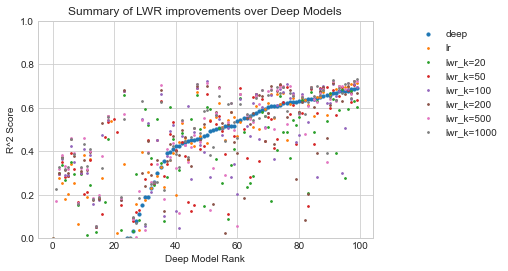

In [12]:
#take 1 is a scatter plot - lets, for each dataset
#graph our deep models by rank - plot - then overlay our knn moels
#plot points

deep_set = scores_df[scores_df["predictor"]=="deep"].sort_values("R2")
deep_set["order"] = [i for i in range(0,100)]
deep_ordering = {row["model_num"]:row["order"] for index, row in deep_set.iterrows()}

def order_models(x):
    x = [deep_ordering[i] for i in x]
    return x

fig, ax = plt.subplots()
set_deep = False
knn_models = scores_df["predictor"].unique()
for knn_model in knn_models:
    subset = scores_df[scores_df["predictor"]==knn_model]
    s=3
    if knn_model == "deep":
        s=10
    ax.scatter(x=order_models(subset["model_num"].tolist()), y=subset["R2"], s=s, label=knn_model)

#ax.set_ylim(0,scores_db["deep_mean"].max())
ax.set_ylim(0,1)
# plot residuals
ax.legend(loc='upper right',bbox_to_anchor=(1.4, 1))
ax.set_ylabel("R^2 Score")
ax.set_xlabel("Deep Model Rank")
#ax.set_ylim(0,200)
#ax.set_yscale("symlog")
ax.set_title("Summary of LWR improvements over Deep Models")
plt.savefig(log_dir/f"summary_plot.png", bbox_inches='tight')
logging.getLogger().info("Wrote Summary Graph")